# Importing Necessary Libraries

In [54]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import defaultdict
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve
from itertools import compress
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

'''
TODO:

1. Try to improve

2. Desing the replace_val for each column

3. Creat preprocess procedure for every class.

4. Put confusion matrix after all training
'''


%matplotlib inline

rs = 101

 # Task 1. Data Selection and Distribution. 

In [55]:
## Read Data
df = pd.read_csv("CaseStudyData.csv")

 ### 1. What is the proportion of cars who can be classified as a “kick”? 

In [56]:
## Exploring the features in this dataset
print("Number of Columns: ", len(df.columns))
print("Columns: ",list(df.columns))

Number of Columns:  31
Columns:  ['PurchaseID', 'PurchaseTimestamp', 'PurchaseDate', 'Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale', 'IsBadBuy']


In [57]:
print("Number of Observations: ", len(df))

Number of Observations:  41476


In [58]:
proportionOfKicks = len(df[df['IsBadBuy'] == 1]) / len(list(df['IsBadBuy']))
print("The proportion of kicks: ", proportionOfKicks)

The proportion of kicks:  0.1294965763333012


### 2. Did you have to fix any data quality problems? Detail them.

In [59]:
#### PREPROCESSING STATEGY
NEW_STATEGY = True
ResamplingMethod = 'rus' #['ros', 'rus']
if NEW_STATEGY:
    print("Using New Preprocessing Strategy")
    using_cat = False
    categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
    interval_cols = ['VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','VehBCost','WarrantyCost' ] 
    drop_cols = ['PurchaseID','PurchaseDate','PurchaseTimestamp']
    questionMark_data = ['MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio']
    replaced_vals = ['?', '#VALUE!']
    if using_cat:
        categorial_cols += questionMark_data
        print("See [MMRCurrentAuctionAveragePrice" +
              "MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice," +
              " MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Categorial Data")
    else: 
        interval_cols += questionMark_data
        print("See [MMRCurrentAuctionAveragePrice" +
              "MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice," +
              " MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Interval Data")
else:
    print("Using Old Preprocessing Strategy")
    drop_cols = ['PurchaseID','PurchaseDate']
    categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
    interval_cols = ['PurchaseTimestamp', 'VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost' ] # Replaced by the mean
    replaced_vals = ['?', '#VALUE!']

print("Total null before Replacing: ", df.isnull().sum().sum())

Using New Preprocessing Strategy
See [MMRCurrentAuctionAveragePriceMMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice, MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Interval Data
Total null before Replacing:  1691


In [60]:
def printColumnInfo():
    
    '''
    Display the information of this Dataframe
    '''
    
    for colName in df.columns:
        print("======================= " + str(colName) + " =======================")
        print("----------------------- FIRST FIVE -----------------------")
        print(df[colName][:5])
        print("----------------------- DESCIRBE -----------------------")
        print(df[colName].describe())
        print("----------------------- COUNTS -----------------------")
        commonList = list(df[colName].value_counts().keys())
        if len(commonList) > 100:
            print("Five Most Common: ", commonList[:5])
        else:
            print("Count List: \n", df[colName].value_counts())
        print("Num of NULL: ", df[colName].isnull().sum())
        for rep in replaced_vals:
            print("Number of "+str(rep)+" : " + str(len(df[df[colName] == rep])))
printColumnInfo()

======================= PurchaseID =======================
----------------------- FIRST FIVE -----------------------
0    0
1    1
2    2
3    3
4    4
Name: PurchaseID, dtype: int64
----------------------- DESCIRBE -----------------------
count    41476.000000
mean     20737.500000
std      11973.234219
min          0.000000
25%      10368.750000
50%      20737.500000
75%      31106.250000
max      41475.000000
Name: PurchaseID, dtype: float64
----------------------- COUNTS -----------------------
Five Most Common:  [2047, 11567, 15693, 13644, 3403]
Num of NULL:  0
Number of ? : 0
Number of #VALUE! : 0
======================= PurchaseTimestamp =======================
----------------------- FIRST FIVE -----------------------
0    1253232000
1    1253232000
2    1253232000
3    1253232000
4    1253232000
Name: PurchaseTimestamp, dtype: int64
----------------------- DESCIRBE -----------------------
count    4.147600e+04
mean     1.262260e+09
std      1.796895e+07
min      1.231114e+09


Five Most Common:  ['0', '5480', '6311', '7811', '7644']
Num of NULL:  60
Number of ? : 7
Number of #VALUE! : 0
======================= MMRAcquisitionAuctionCleanPrice =======================
----------------------- FIRST FIVE -----------------------
0    9325
1    9325
2    9428
3    7770
4    9325
Name: MMRAcquisitionAuctionCleanPrice, dtype: object
----------------------- DESCIRBE -----------------------
count     41429
unique    10010
top           0
freq        415
Name: MMRAcquisitionAuctionCleanPrice, dtype: object
----------------------- COUNTS -----------------------
Five Most Common:  ['0', '6461', '7450', '1', '8258']
Num of NULL:  47
Number of ? : 7
Number of #VALUE! : 0
======================= MMRAcquisitionRetailAveragePrice =======================
----------------------- FIRST FIVE -----------------------
0     9751
1     9751
2    10042
3     8238
4     9751
Name: MMRAcquisitionRetailAveragePrice, dtype: object
----------------------- DESCIRBE -----------------------
co

In [61]:
if NEW_STATEGY:

    class filling_method():
        MOST_COMMON = "MOST_COMMON"
        MEAN = "MEAN"
        CERTAIN_VALUE = "CERTAIN_VALUE"

    def replaceFunc(colName):
        for replaced, target in preprocessStrategy[colName]['replace_pairs']:
            df[colName].replace(replaced, target, inplace=True)

    def removeOutlier(colName):  # FOR THE INTERVAL ONLY
        global df
        df = df[df[colName] < df[colName].quantile(0.999)]

    def replacingValueCol(colName):
        for replaced in preprocessStrategy[colName]['replaced_vals']:
            print("In the Column: " + str(colName) + " : " + str(len(
                df[df[colName] == replaced])) + ", " + str(replaced) + "have been replaced by null")
            # Replacing the null in this process #Inplacing for saving the memory
            df[colName].replace(replaced, float('nan'), inplace=True)

    def loweringCol(colName):
        df[colName] = df[colName].str.lower()

    def fillingTheNullValue(colName):  # method can be ["MEAN", "MOST_COMMON"]
        if preprocessStrategy[colName]['filling_method'] == filling_method.MEAN:
            df[colName] = df[colName].astype('float')
            df[colName].fillna(df[colName].astype(
                'float').mean(), inplace=True)
        elif preprocessStrategy[colName]['filling_method'] == filling_method.MOST_COMMON:
            df[colName] = df[colName].astype('category')
            df[colName].fillna(df[colName].astype(
                'category').describe()['top'], inplace=True)
        elif preprocessStrategy[colName]['filling_method'] == filling_method.CERTAIN_VALUE:
            df[colName] = df[colName].astype('category')
            df[colName] = df[colName].cat.add_categories(
                [preprocessStrategy[colName]['filling_value']])
            df[colName].fillna(preprocessStrategy[colName]
                               ['filling_value'], inplace=True)

    def filterOutRareValue(colName):

        def checkingKeepValue(v, savingValues):
            if v in savingValues:
                return v
            return "LESS_FREQ"

        k = [v for v in df[colName].value_counts().values if v >
             preprocessStrategy[colName]['min_freq']]
        savingValues = df[colName].value_counts().keys()[:len(k)]

        df[colName] = [checkingKeepValue(v, savingValues) for v in df[colName]]

    def changeToType(colName):
        df[colName] = df[colName].astype(
            preprocessStrategy[colName]['changeToType'])

    def newData_prep(df):
        '''
        For Preprocessing through the whole dictionary
        '''
        df.drop(drop_cols, axis=1, inplace=True)

        for colName in df.columns:  # df.columns:

            print("Preprocess the col: " + colName)

            for stra in preprocessStrategy[colName]['strategies']:
                if not stra:
                    continue
                stra(colName)

        if not using_cat:
            df['MMRCurrentRetailRatio'] = df['MMRCurrentRetailAveragePrice'] / \
                (df['MMRCurrentRetailCleanPrice']+1e-8)  # Prvent divided by 0

        return df

    preprocessStrategy = defaultdict(dict)

    preprocessStrategy['Auction'] = {
        "strategies":
            [
                replacingValueCol,
                loweringCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['VehYear'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": "UNKNOWN_VALUE"
    }

    preprocessStrategy['Make'] = {
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['Color'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['Transmission'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['WheelTypeID'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['WheelType'] = {
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['VehOdo'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['Nationality'] = {  # Should I merge USA with AMERICAN?
        "strategies":
            [
                replaceFunc,
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON,
        "replace_pairs": [("USA", "AMERICAN")]

    }

    preprocessStrategy['Size'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON

    }

    preprocessStrategy['TopThreeAmericanName'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['TopThreeAmericanName'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['MMRAcquisitionAuctionAveragePrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitionAuctionCleanPrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitionRetailAveragePrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitonRetailCleanPrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    ###############################################################
    int_stra = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', '#VALUE!'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN,
    }

    cat_stra = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                filterOutRareValue,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
        "min_freq": 50
    }

    preprocessStrategy['MMRCurrentAuctionAveragePrice'] \
        = preprocessStrategy['MMRCurrentAuctionCleanPrice'] \
        = preprocessStrategy['MMRCurrentRetailAveragePrice'] \
        = preprocessStrategy['MMRCurrentRetailCleanPrice'] \
        = preprocessStrategy['MMRCurrentRetailRatio'] \
        = cat_stra if using_cat else int_stra

    ###############################################################

    preprocessStrategy['PRIMEUNIT'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['AUCGUART'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['VNST'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['VehBCost'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                replacingValueCol,

                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['IsOnlineSale'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                replacingValueCol,
                changeToType,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', 2.0, 4.0],  # GOT 184 '?'
        "filling_method": filling_method.MOST_COMMON,
        "changeToType": 'float'
    }

    preprocessStrategy['WarrantyCost'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN,
    }

    preprocessStrategy['ForSale'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', 0],  # GOT 184 '?'
        "filling_method": filling_method.MOST_COMMON,
    }

    # HOW DO WE DEAL WITH ? in this column
    preprocessStrategy['IsBadBuy'] = {"strategies": [None]}

    newData_prep(df)


else:

    def data_prep(df):
        '''
        For Preprocessing the Data (OLD_METHOD)
        '''

        # Check the replaced values are not in the dataset

        for colName in df.columns:

            if colName in categorial_cols:

                if colName == "IsOnlineSale":
                    df[colName] = df[colName].astype(
                        'float').astype('category')
                    df[colName].fillna(df[colName].astype(
                        'category').describe()['top'], inplace=True)

                # Try to lower the data if the data type is string
                try:
                    df[colName] = df[colName].str.lower()
                except:
                    print(colName, " can't be lowered")

                for replaced in replaced_vals:
                    print("In the Column: " + str(colName) + ": " +
                          str(len(df[df[colName] == replaced])) + " -> " + str(replaced))
                    df[colName].replace(replaced, float('nan'), inplace=True)

                df[colName] = df[colName].astype('category')

                # Replacing the null by the most common category
                df[colName].fillna(df[colName].astype(
                    'category').describe()['top'], inplace=True)

            if colName in interval_cols:

                if colName == "MMRCurrentRetailRatio":  # Dealing with this calculated value at the last
                    continue

                for replaced in replaced_vals:
                    print("In the Column: " + str(colName) + ": " +
                          str(len(df[df[colName] == replaced])) + " -> " + str(replaced))
                    df[colName].replace(replaced, float('nan'), inplace=True)

                df[colName] = df[colName].astype('float')

                # Removing outlier
                df = df[df[colName] < df[colName].quantile(0.999)]

                # Replacing the null by the mean
                df[colName].fillna(df[colName].astype(
                    'float').mean(), inplace=True)

        df['MMRCurrentRetailRatio'] = df['MMRCurrentRetailAveragePrice'] / \
            (df['MMRCurrentRetailCleanPrice']+1e-8)  # Prvent divided by 0

        df.drop(drop_cols, axis=1, inplace=True)

        return df

    df = data_prep(df)


Preprocess the col: Auction
In the Column: Auction : 0, ?have been replaced by null
Preprocess the col: VehYear
Preprocess the col: Make
Preprocess the col: Color
In the Column: Color : 6, ?have been replaced by null
Preprocess the col: Transmission
In the Column: Transmission : 6, ?have been replaced by null
Preprocess the col: WheelTypeID
Preprocess the col: WheelType
Preprocess the col: VehOdo
Preprocess the col: Nationality
In the Column: Nationality : 3, ?have been replaced by null
Preprocess the col: Size
In the Column: Size : 3, ?have been replaced by null
Preprocess the col: TopThreeAmericanName
In the Column: TopThreeAmericanName : 3, ?have been replaced by null
Preprocess the col: MMRAcquisitionAuctionAveragePrice
In the Column: MMRAcquisitionAuctionAveragePrice : 7, ?have been replaced by null
Preprocess the col: MMRAcquisitionAuctionCleanPrice
In the Column: MMRAcquisitionAuctionCleanPrice : 7, ?have been replaced by null
Preprocess the col: MMRAcquisitionRetailAveragePrice

### 3. Can you identify any clear patterns by initial exploration of the data using histogram or box plot?

In [62]:
def plotAllCols (df):
    for colName in df.columns:
        plt.figure(figsize=(20,10))
        if colName in categorial_cols:
            ### if it's categorial column, plot hist diagram 
            sns.countplot(x=colName, data = df, hue="IsBadBuy")
        elif colName in interval_cols:
            ### if it's interval column, plot box diagram
            sns.boxplot(x="IsBadBuy", y=colName, data = df )

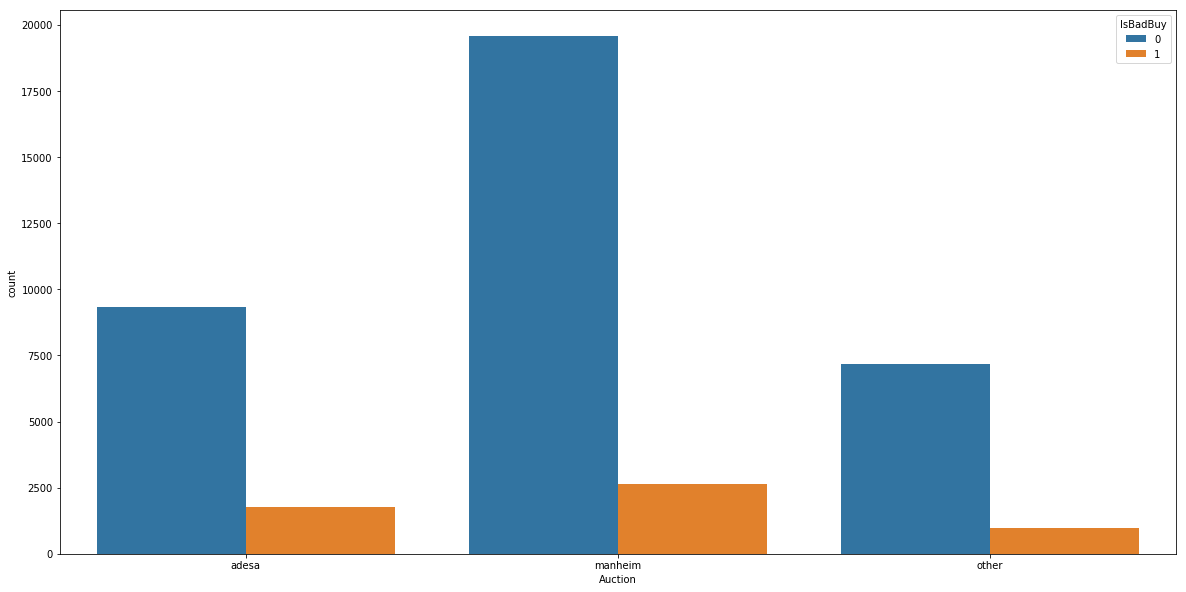

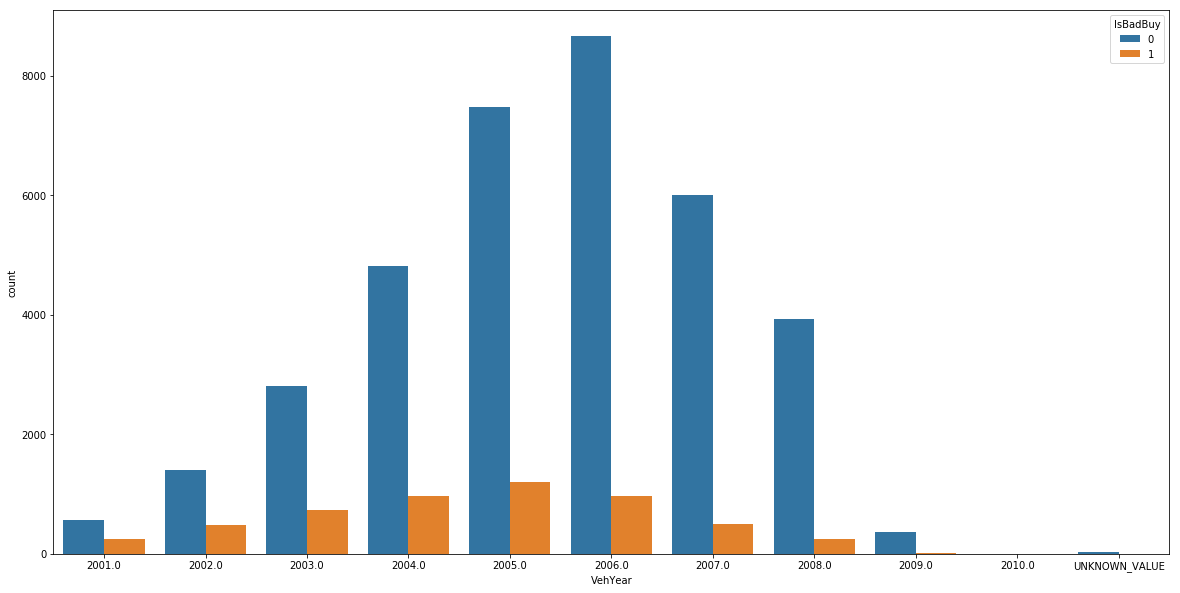

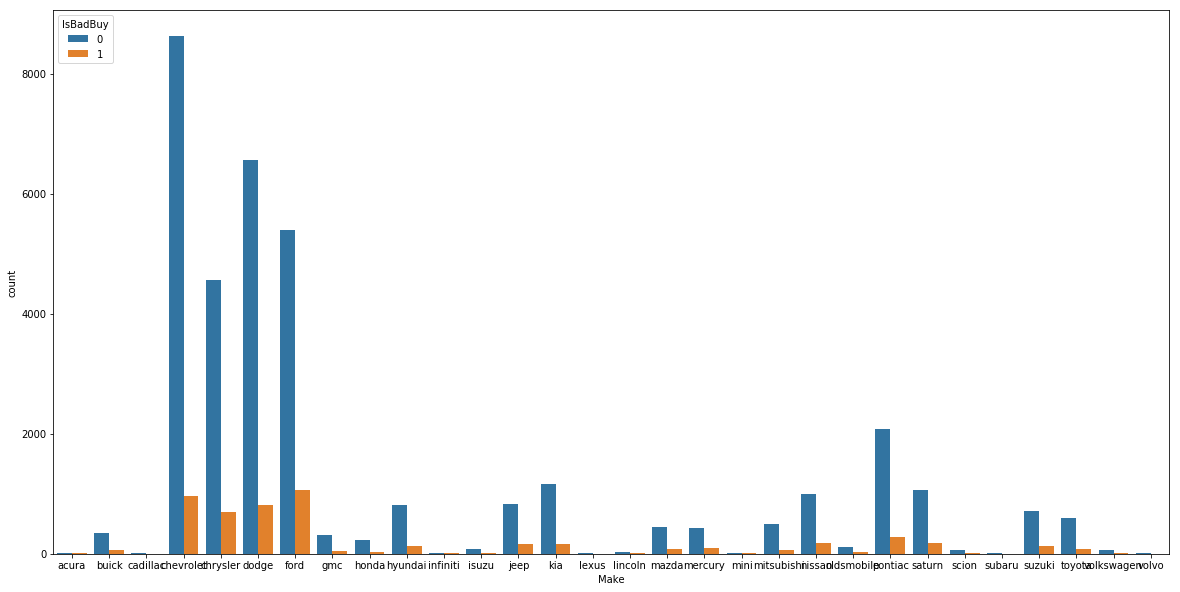

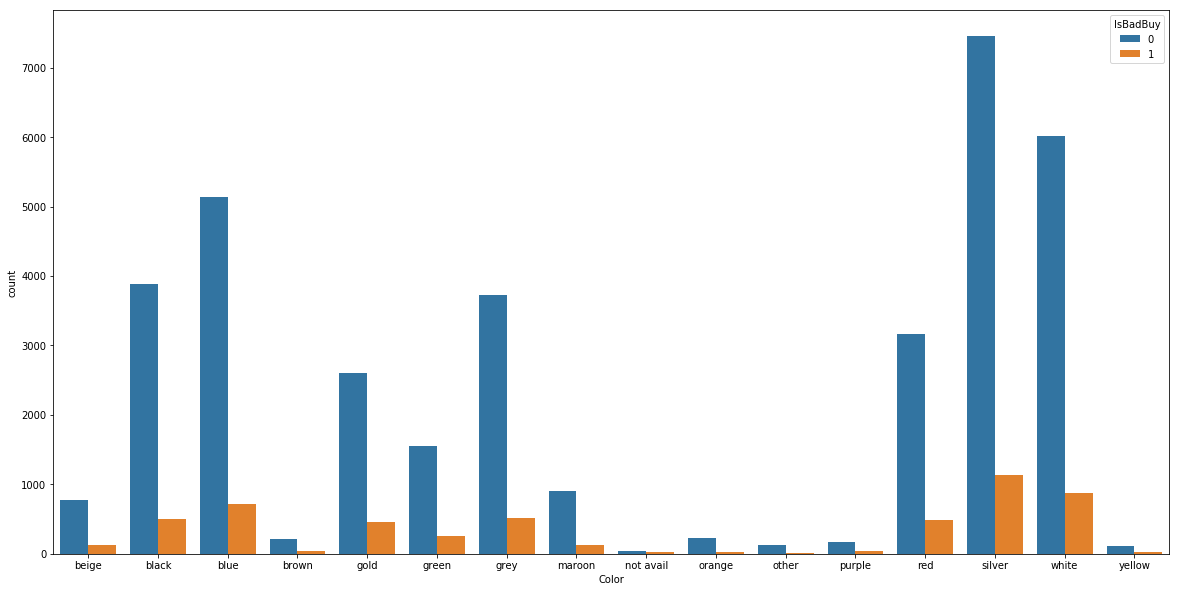

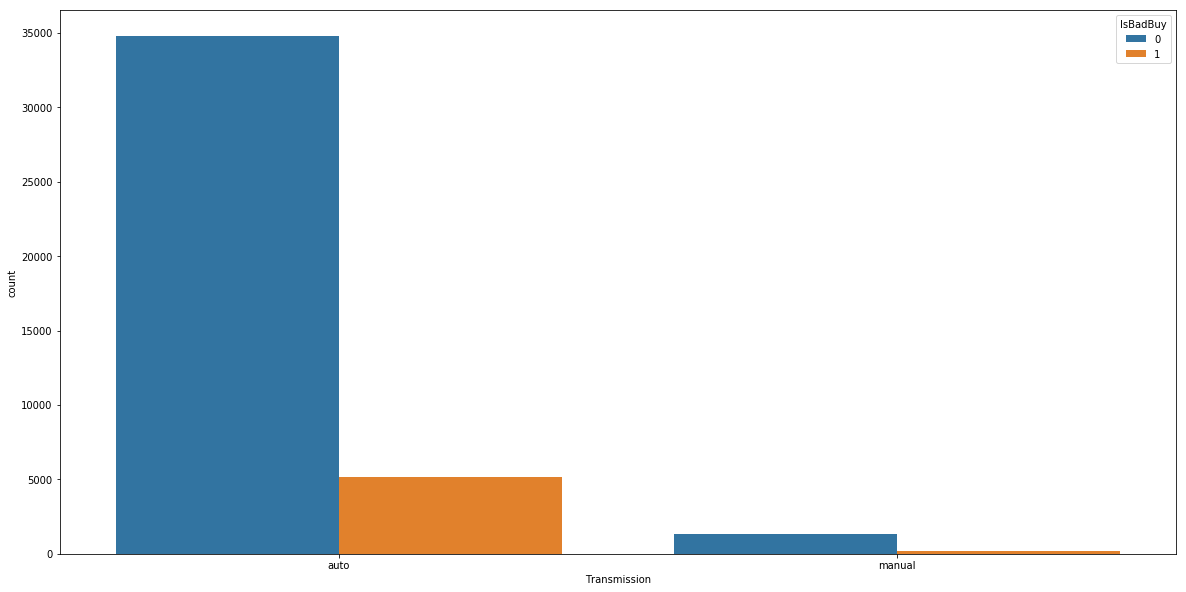

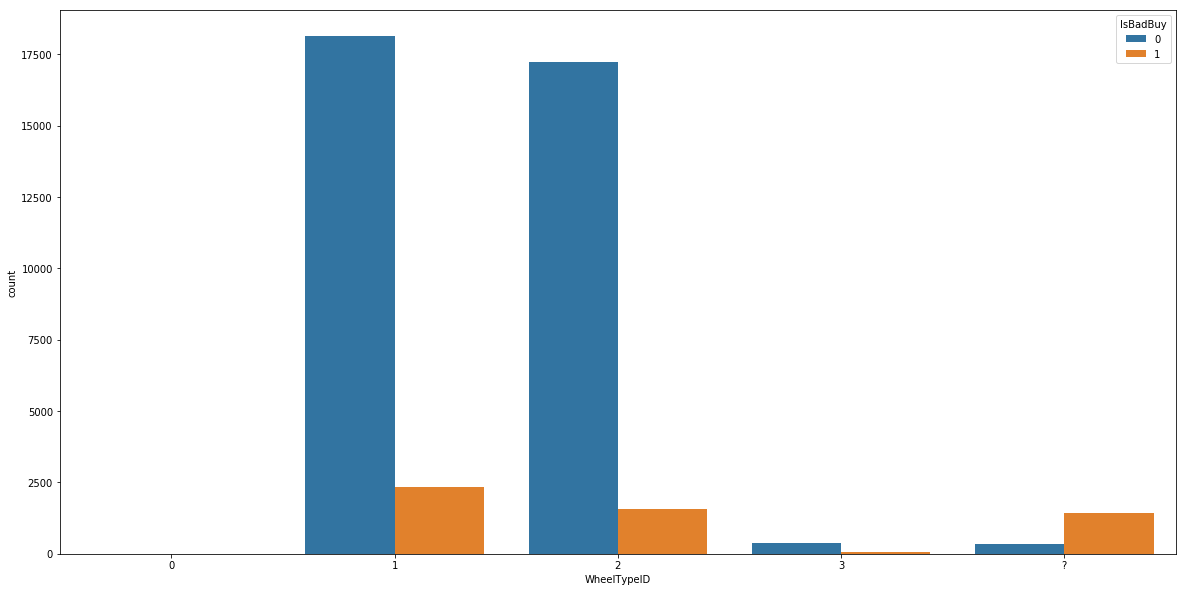

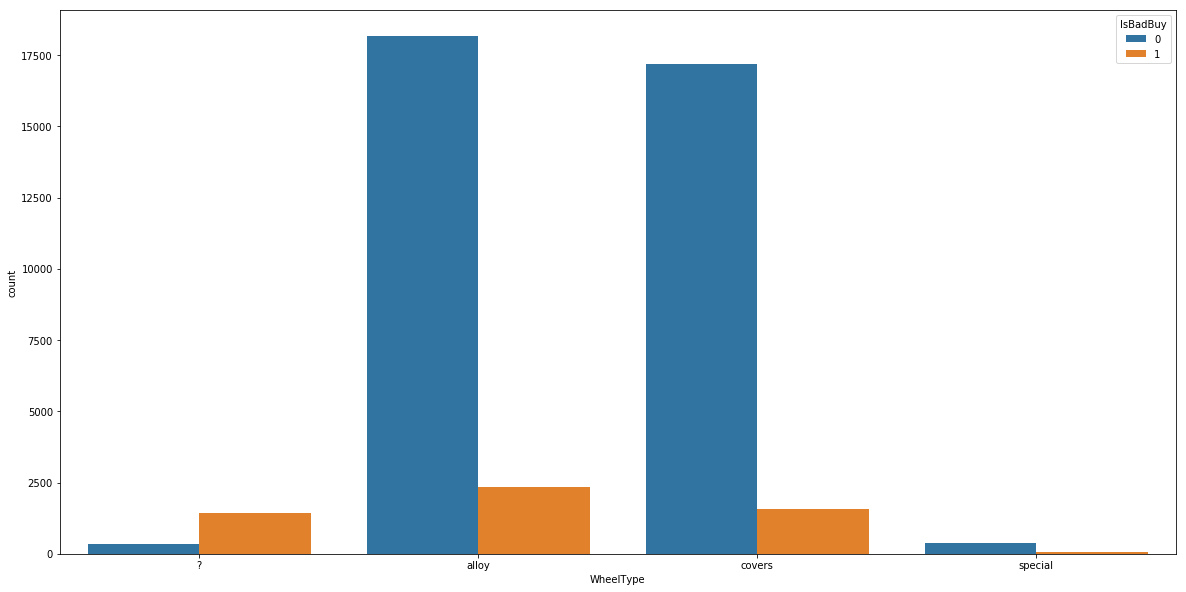

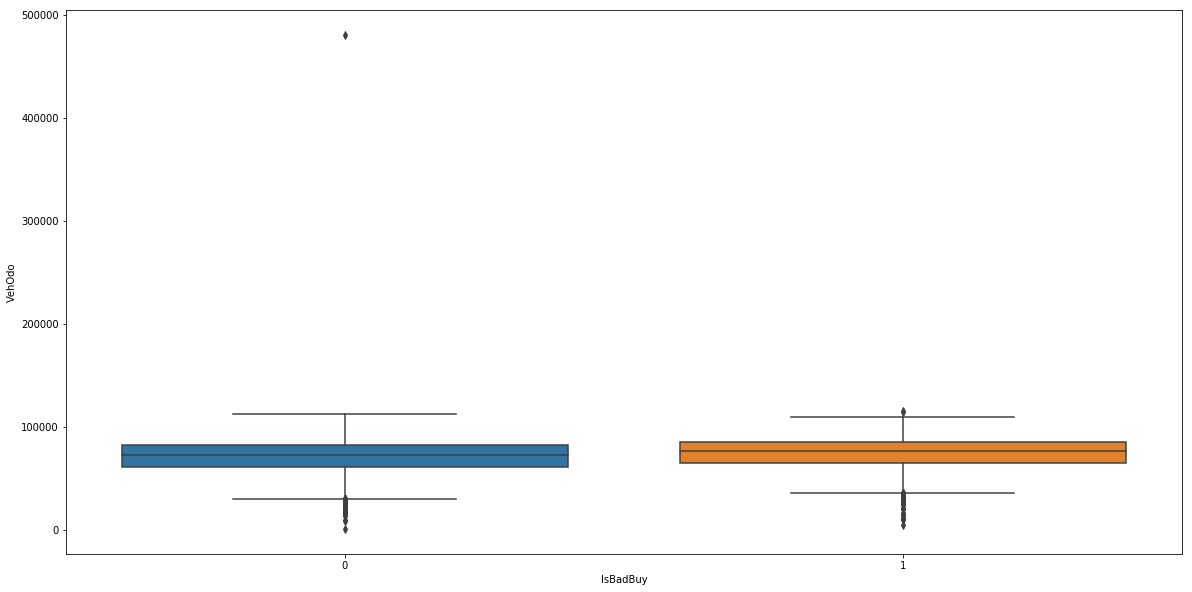

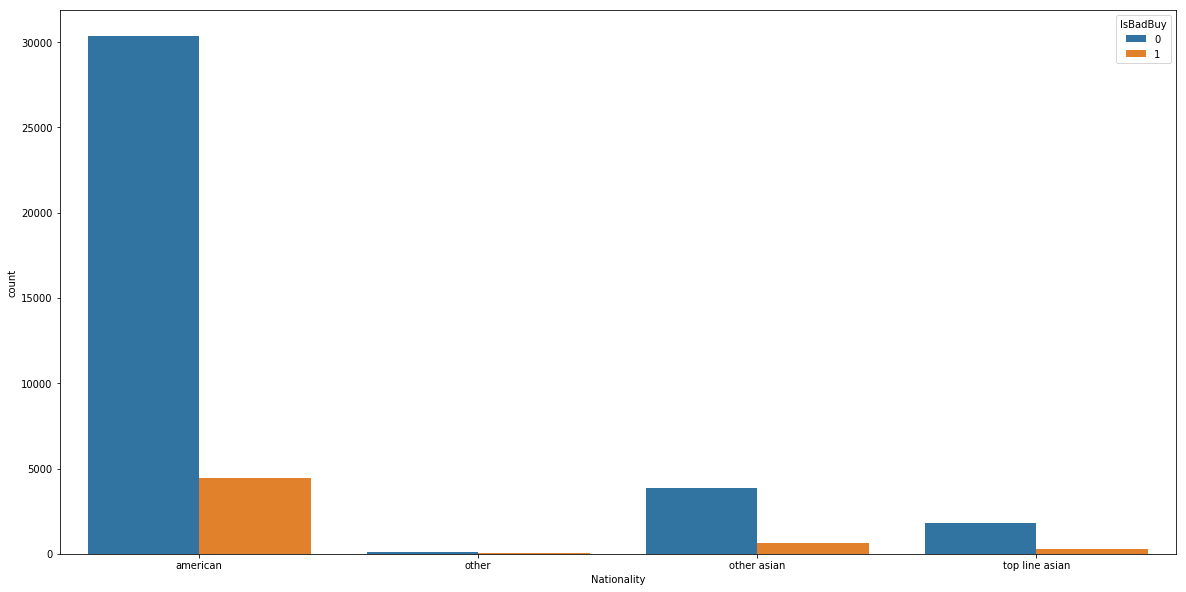

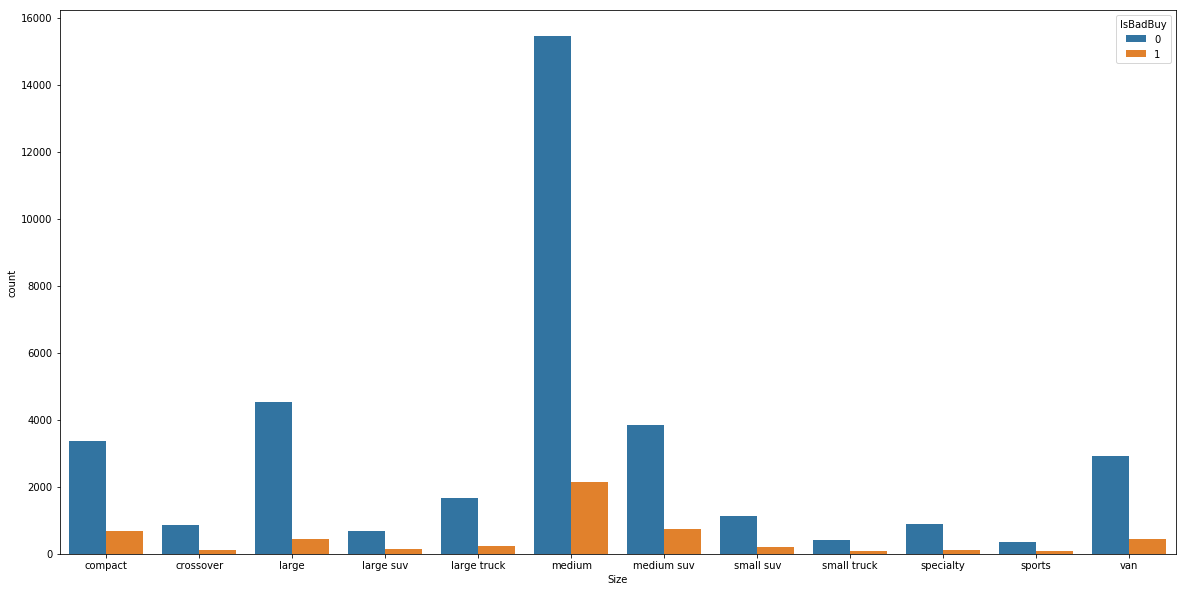

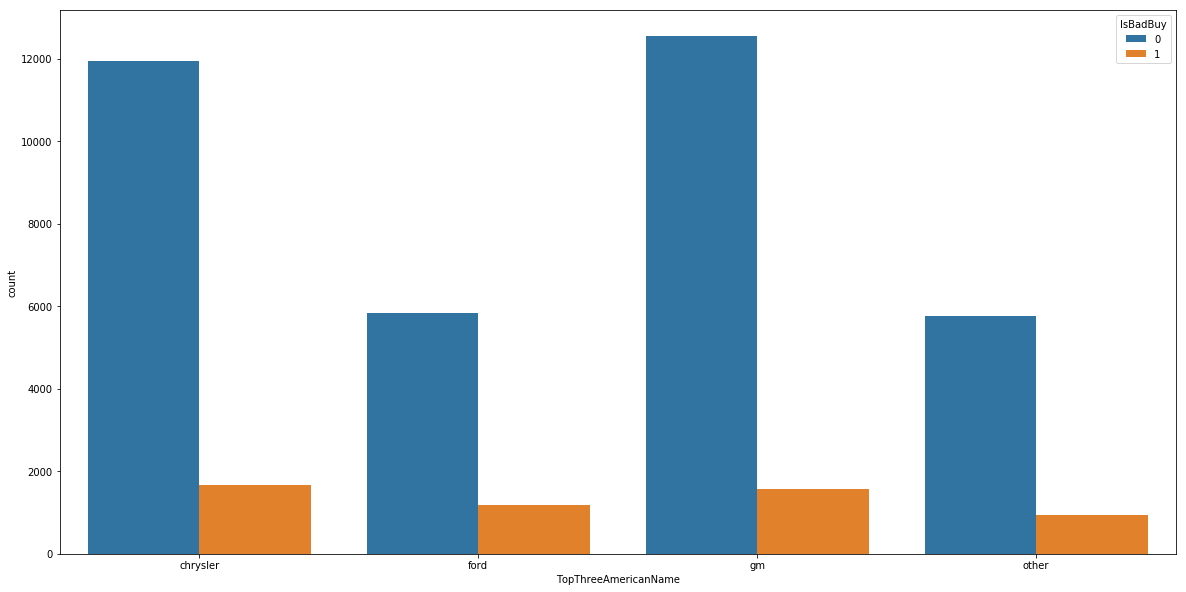

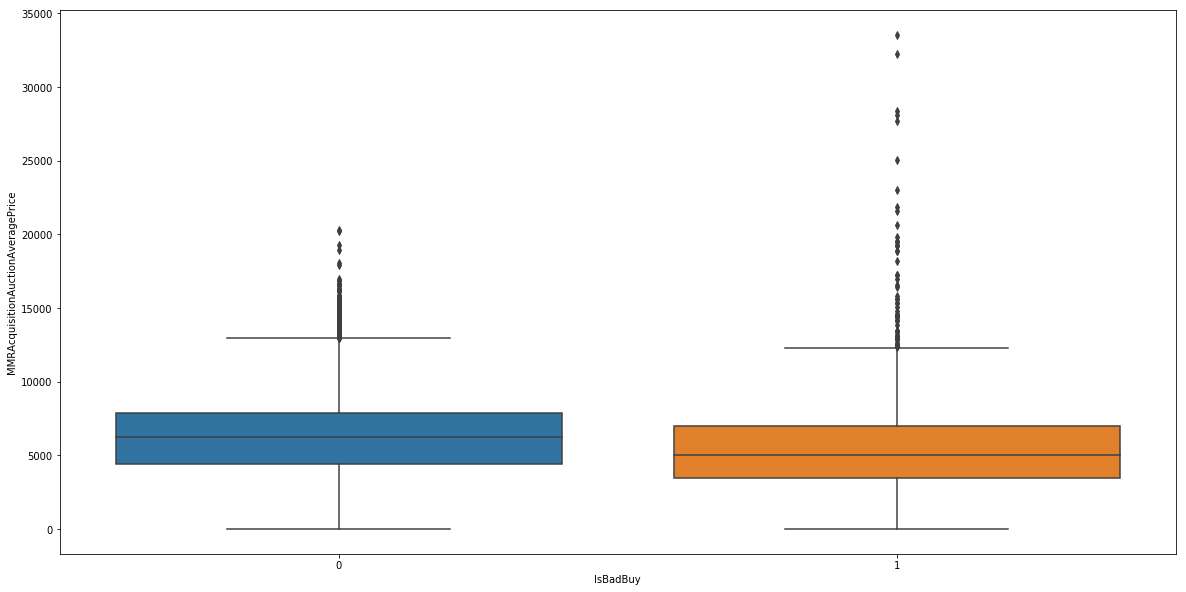

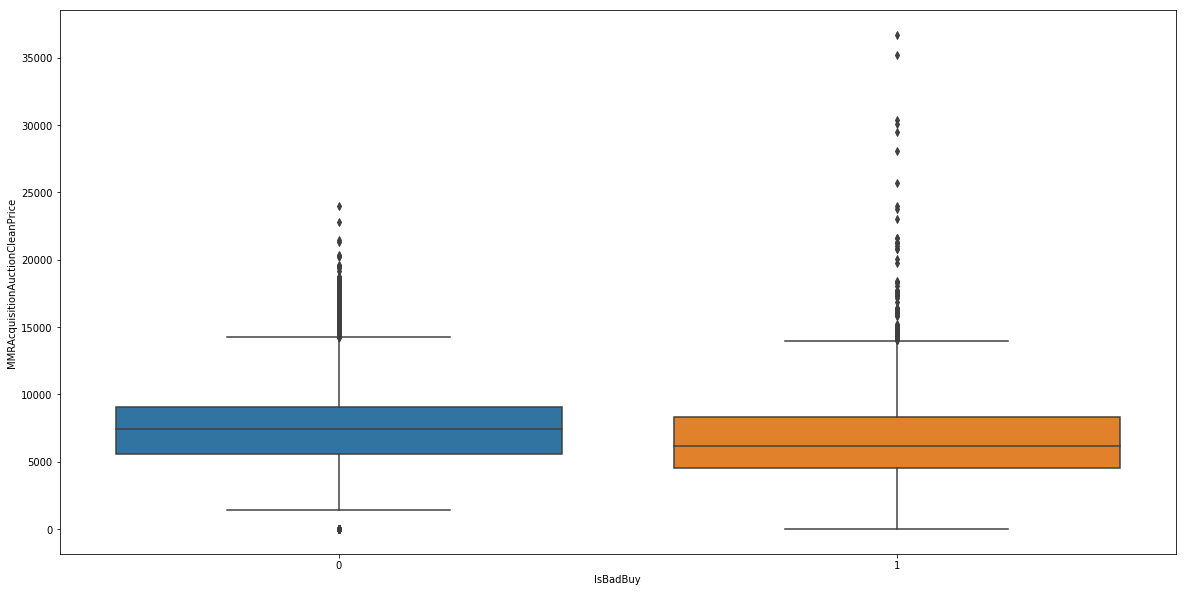

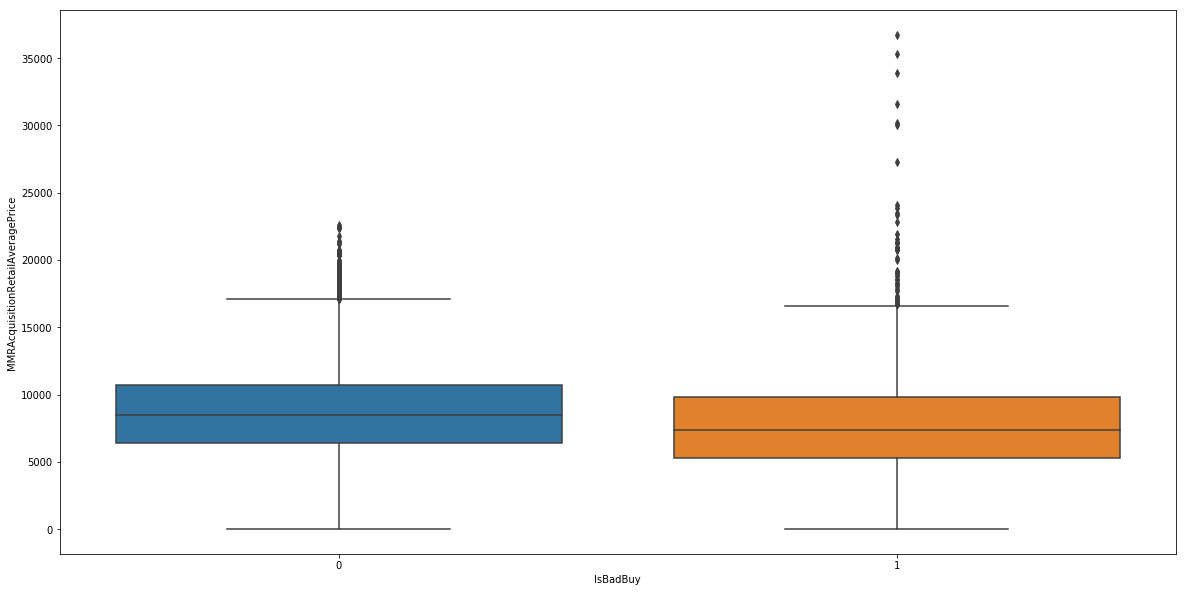

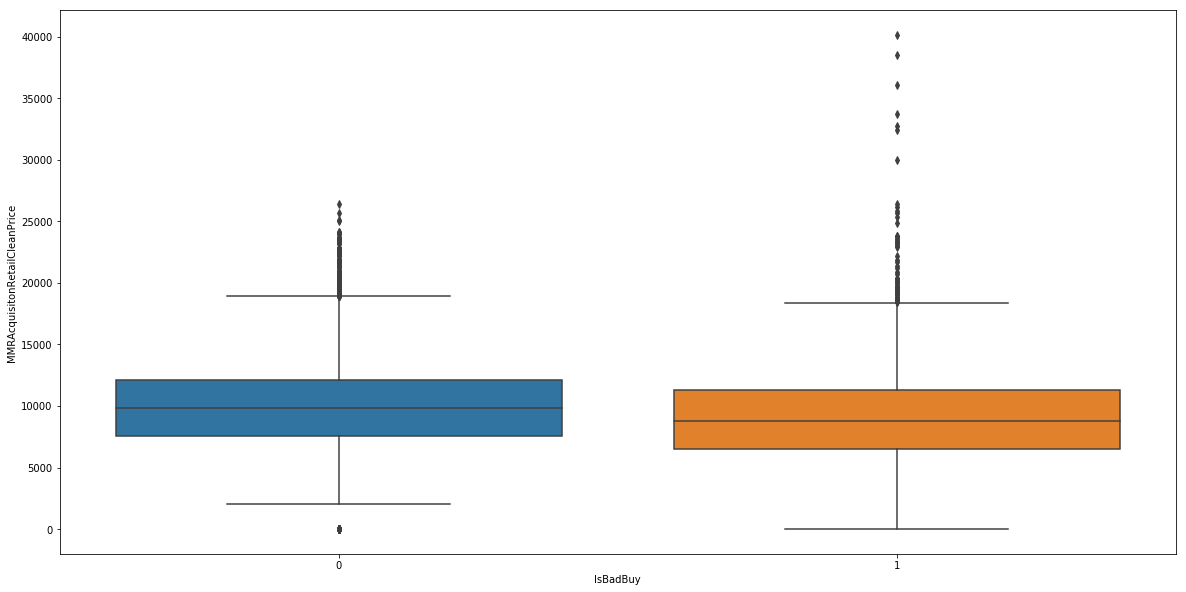

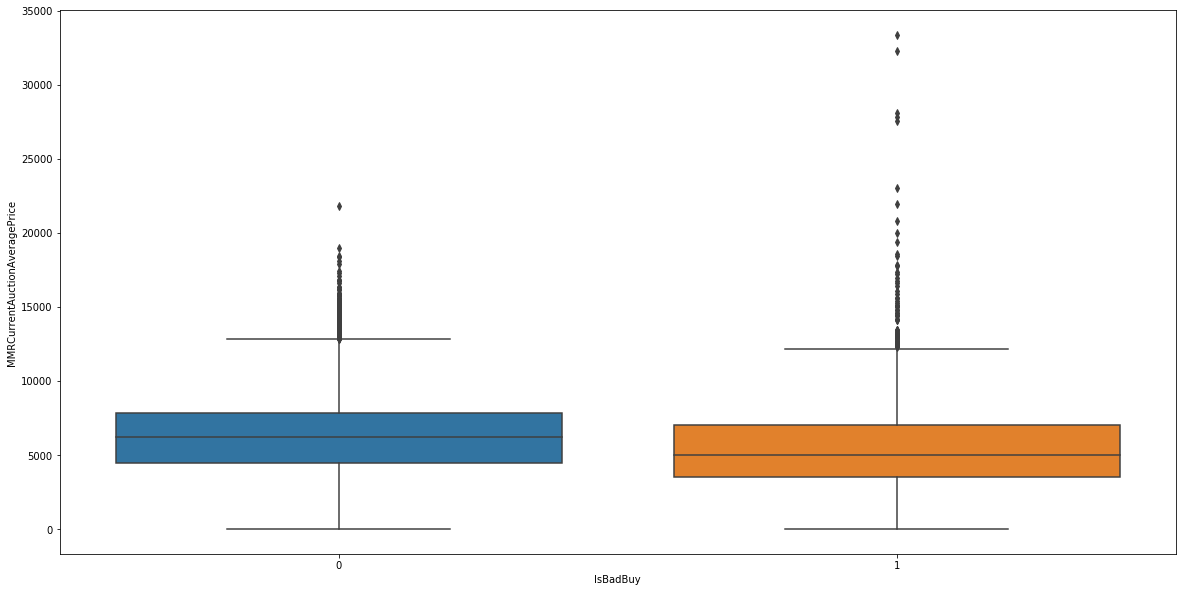

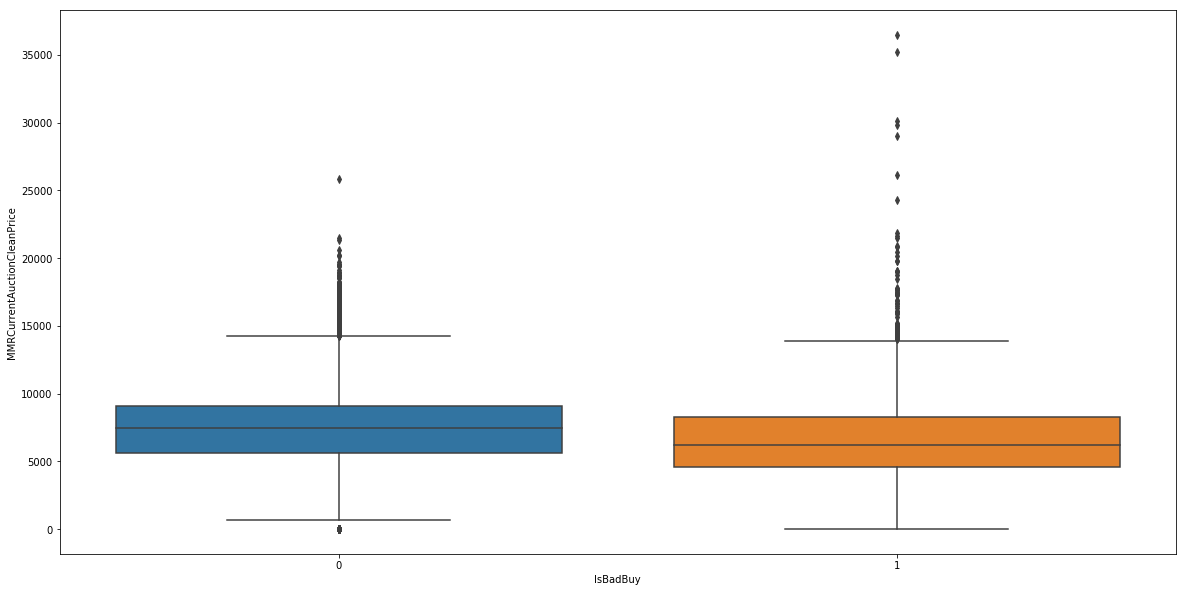

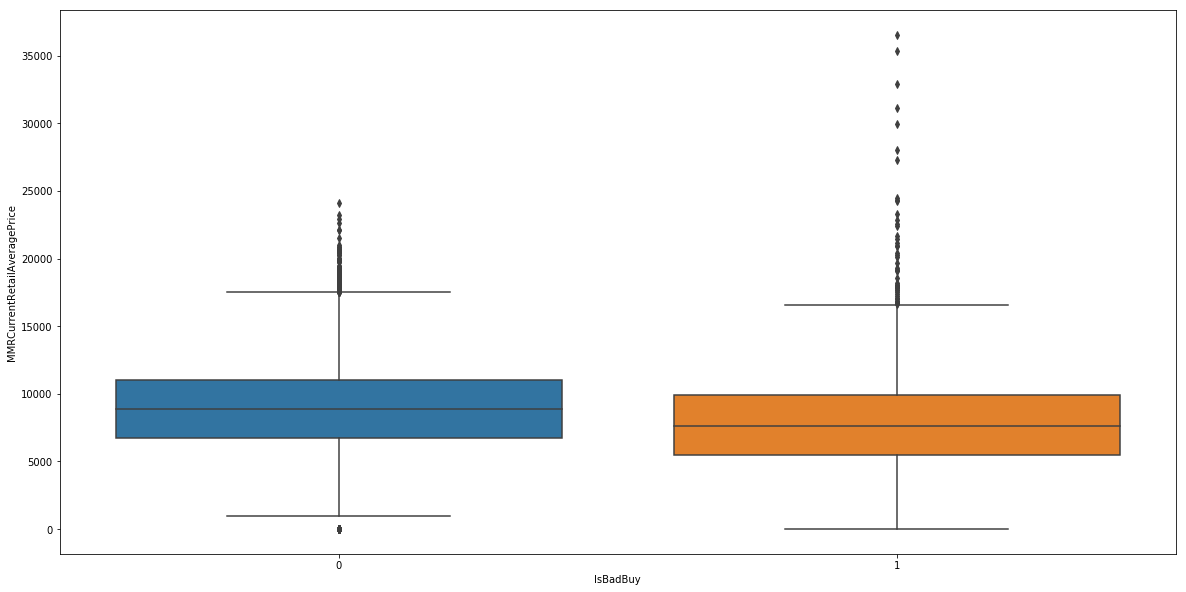

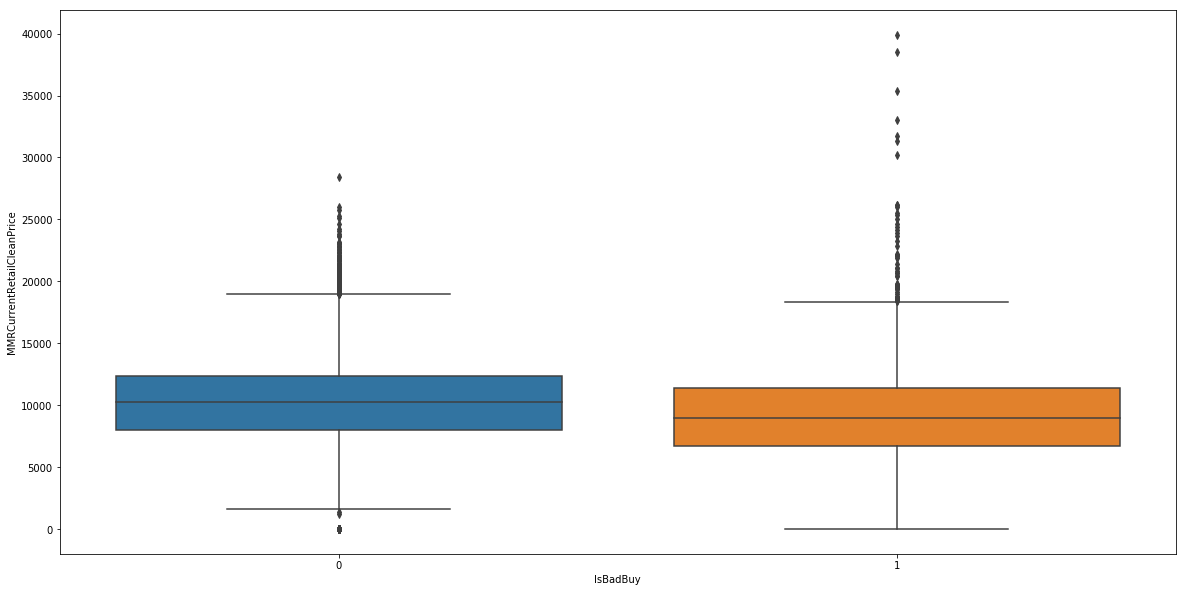

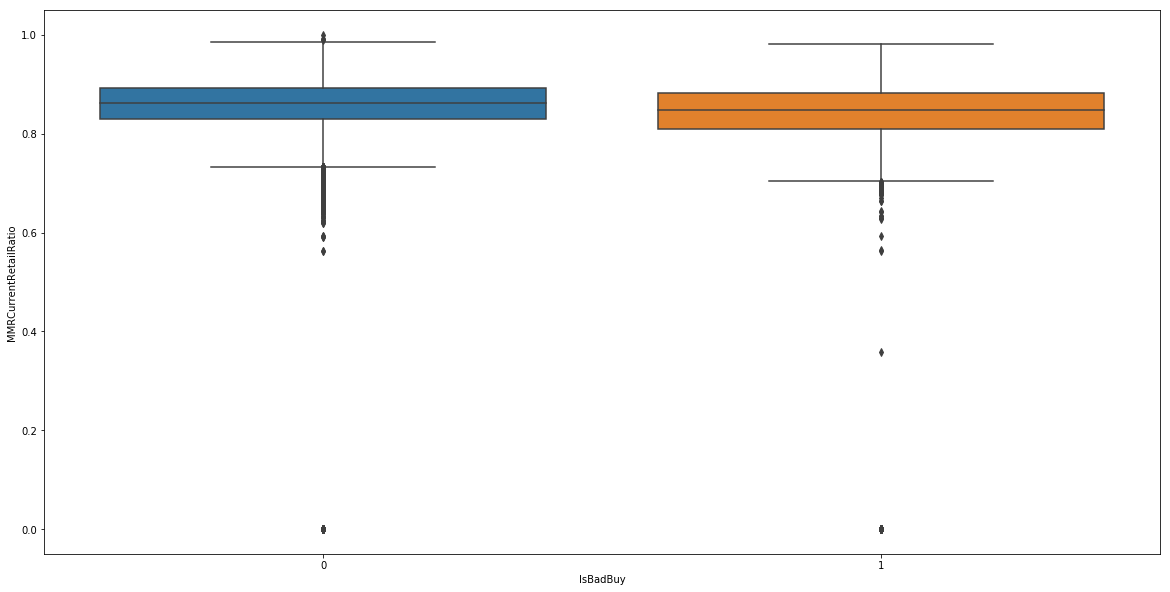

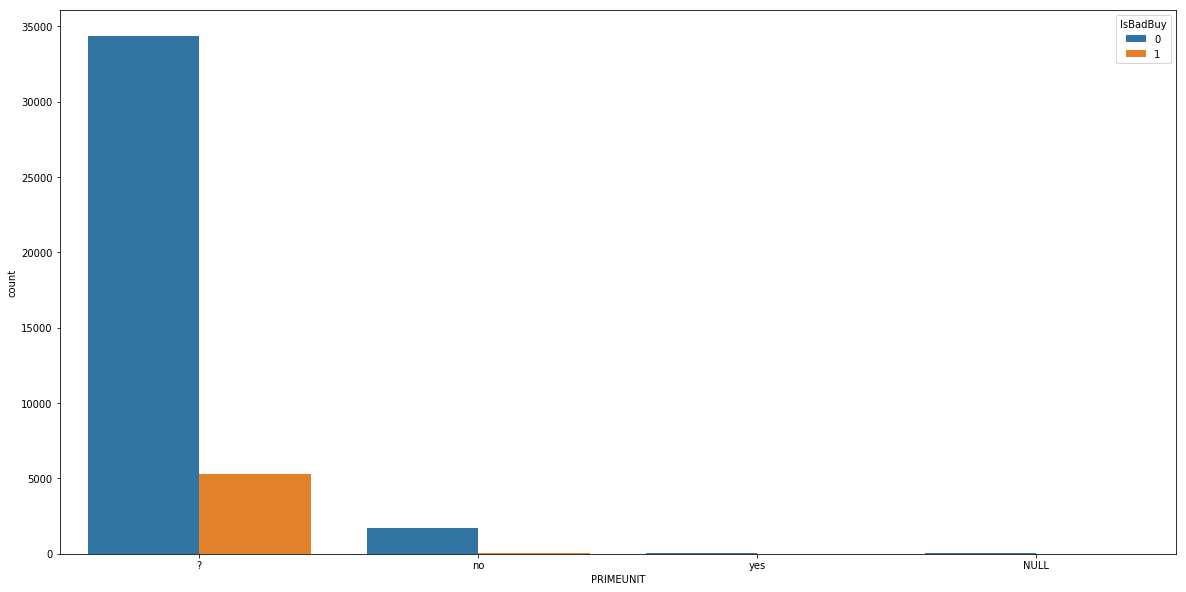

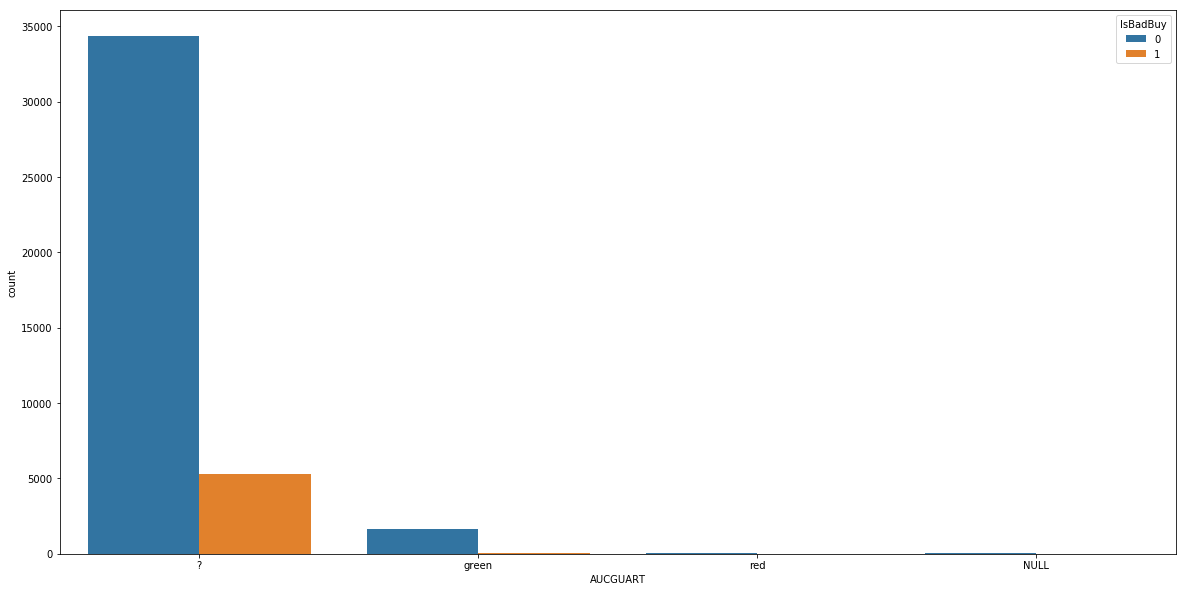

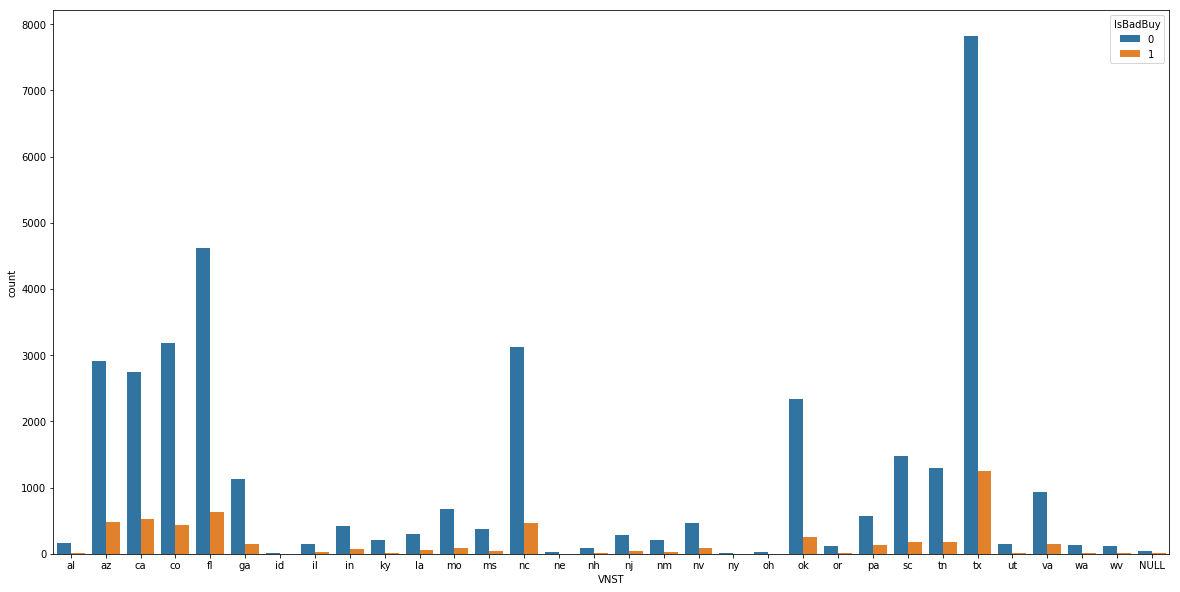

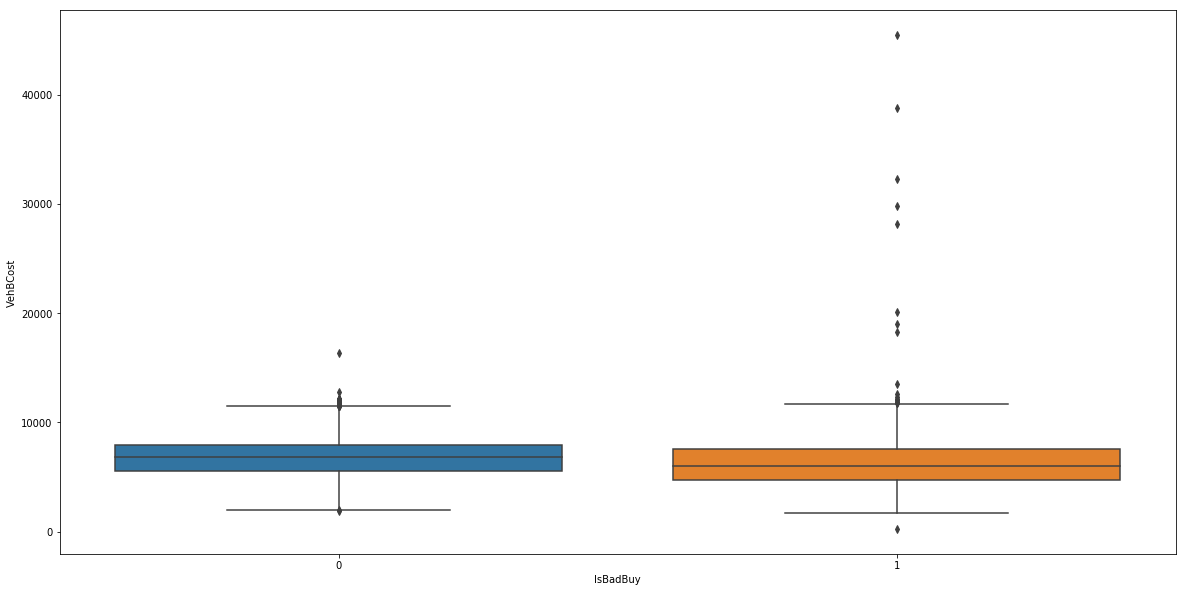

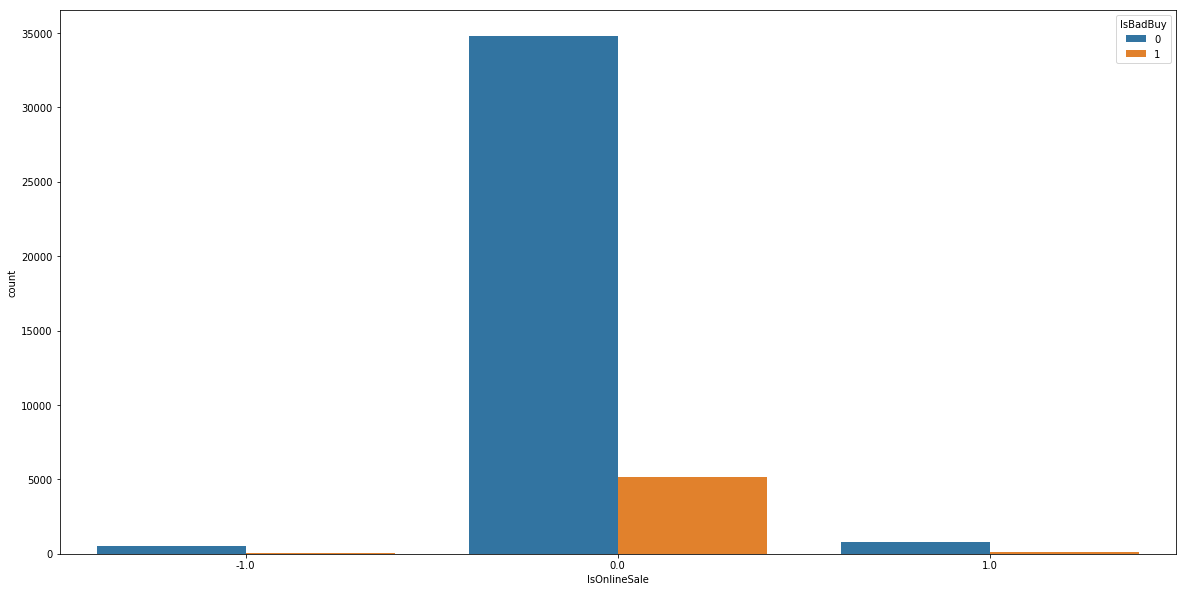

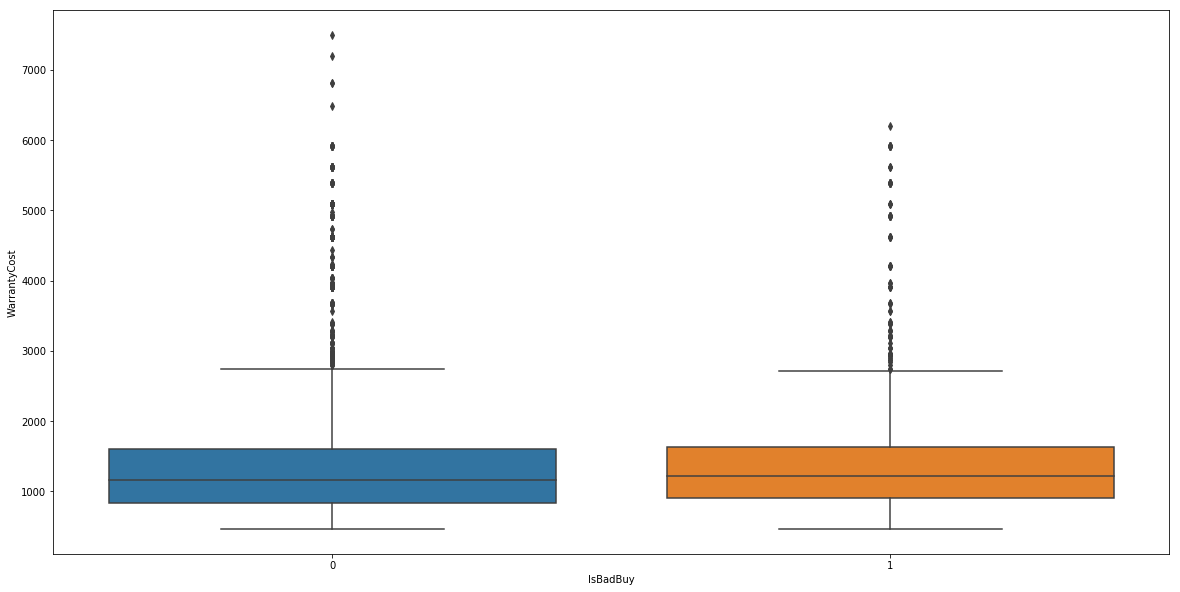

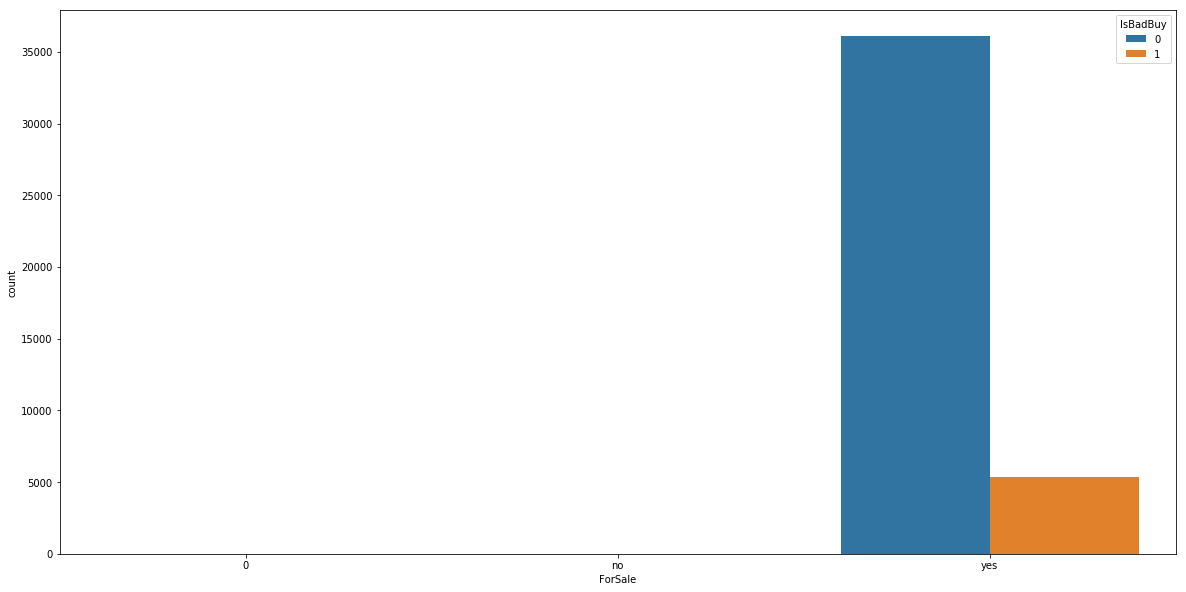

<Figure size 1440x720 with 0 Axes>

In [63]:
plotAllCols(df)

### 4. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice

In [64]:
# Change to the dummy 
feature_names_beforDummy = df.drop("IsBadBuy", axis=1).columns

df = pd.get_dummies(df)

feature_names = df.drop("IsBadBuy", axis=1).columns
print("Num of Features:", len(feature_names))
print("\n\n")
print("The variables that included in the training: ")

for name in feature_names:
    print(str(name) + "\n")

Num of Features: 149



The variables that included in the training: 
VehOdo

MMRAcquisitionAuctionAveragePrice

MMRAcquisitionAuctionCleanPrice

MMRAcquisitionRetailAveragePrice

MMRAcquisitonRetailCleanPrice

MMRCurrentAuctionAveragePrice

MMRCurrentAuctionCleanPrice

MMRCurrentRetailAveragePrice

MMRCurrentRetailCleanPrice

MMRCurrentRetailRatio

VehBCost

WarrantyCost

Auction_adesa

Auction_manheim

Auction_other

VehYear_2001.0

VehYear_2002.0

VehYear_2003.0

VehYear_2004.0

VehYear_2005.0

VehYear_2006.0

VehYear_2007.0

VehYear_2008.0

VehYear_2009.0

VehYear_2010.0

VehYear_UNKNOWN_VALUE

Make_acura

Make_buick

Make_cadillac

Make_chevrolet

Make_chrysler

Make_dodge

Make_ford

Make_gmc

Make_honda

Make_hyundai

Make_infiniti

Make_isuzu

Make_jeep

Make_kia

Make_lexus

Make_lincoln

Make_mazda

Make_mercury

Make_mini

Make_mitsubishi

Make_nissan

Make_oldsmobile

Make_pontiac

Make_saturn

Make_scion

Make_subaru

Make_suzuki

Make_toyota

Make_volkswagen

Make_volvo



In [65]:
# Ly

'''
We want to include all the features without droping the information that may be useful for the training.
Some columns are droped since they may not provide meaningful information for classifying the kicks, such as the ID, Date and TimeStamp.
'''


# drop_cols = ['PurchaseID','PurchaseDate','PurchaseTimestamp']

'\nWe want to include all the features without droping the information that may be useful for the training.\nSome columns are droped since they may not provide meaningful information for classifying the kicks, such as the ID, Date and TimeStamp.\n'

### 5. What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection. 

In [16]:
# strafying sampling, randomOverSampling -> For training set

'''
We use stratify sampling for splitting the training and the test sets, which means the portion of kicks 
in the training and test set will be the same as the original dataset. Moreover, in order to deal with the
imbalanced dataset, we use ROS and RUS to test the performance. However, we only apply ROS and RUS on the training
dataset since we want the test dataset can have the similar distribution to the real world cases.

'''



'\nWe use stratify sampling for splitting the training and the test sets, which means the portion of kicks \nin the training and test set will be the same as the original dataset. Moreover, in order to deal with the\nimbalanced dataset, we use ROS and RUS to test the performance. However, we only apply ROS and RUS on the training\ndataset since we want the test dataset can have the similar distribution to the real world cases.\n\n'

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("IsBadBuy", axis=1), df['IsBadBuy'], test_size=0.3, stratify=df['IsBadBuy'], random_state=rs)

if ResamplingMethod == 'ros':
    print("Using ROS Resmapling")
    ros = RandomOverSampler(random_state=rs)
    X_train, y_train = ros.fit_resample(X_train, y_train)
elif  ResamplingMethod == 'rus':
    print("Using RUS Resmapling")
    rus = RandomUnderSampler(random_state=rs)
    X_train, y_train = rus.fit_resample(X_train, y_train)
else:
    print("No Resampling Method Used")

Using RUS Resmapling


In [18]:
print("Number of Training: ", len(X_train))
print("Number of Test: ", len(X_test) )

Number of Training:  7520
Number of Test:  12443


# Task 2. Predictive Modeling Using Decision Trees 

## 1. Python: Build a decision tree using the default setting. 

In [19]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


In [20]:
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

### a. What is the classification accuracy on training and test datasets?

In [21]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred)) ## Confusion Matrix on the TestSet

Train accuracy: 0.9998670212765958
Test accuracy: 0.6226794181467492
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     10832
           1       0.20      0.62      0.30      1611

   micro avg       0.62      0.62      0.62     12443
   macro avg       0.56      0.62      0.52     12443
weighted avg       0.82      0.62      0.68     12443

Confusion Matrix: 
 [[6743 4089]
 [ 606 1005]]


### b. What is the size of tree (i.e. number of nodes)?

In [16]:
print("Number of nodes: ", model.tree_.node_count)

Number of nodes:  6703


### c. How many leaves are in the tree that is selected based on the validation dataset?

In [22]:
def calculate_num_leaves(dt):
    n_nodes = dt.tree_.node_count
    ll = dt.tree_.children_left
    rl = dt.tree_.children_right
    count = 0
    for i in range(0,n_nodes):
        if (ll[i] & rl[i]) == -1:
            count = count + 1
    return count
print("The number of leaves is ",calculate_num_leaves(model));

The number of leaves is  1373


### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [17]:
visualize_decision_tree(model, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct.png")

### e. What are the 5 important variables in building the tree? 

In [23]:
analyse_feature_importance(model, df.drop("IsBadBuy", axis=1).columns, 5)

WheelTypeID_? : 0.13480585505228698
VehBCost : 0.0697126923506575
VehOdo : 0.06920195012906506
MMRCurrentRetailRatio : 0.06552441838480952
MMRCurrentAuctionAveragePrice : 0.06249076040165891


### f. Report if you see any evidence of model overfitting. 

In [24]:
## Discuss the measurement of overfitting
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.9998670212765958
Test accuracy: 0.6226794181467492


Since the accuracy on the training set is much larger than the test set, it may has the overfitting problem. # LY, pls modify this

### g. Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.

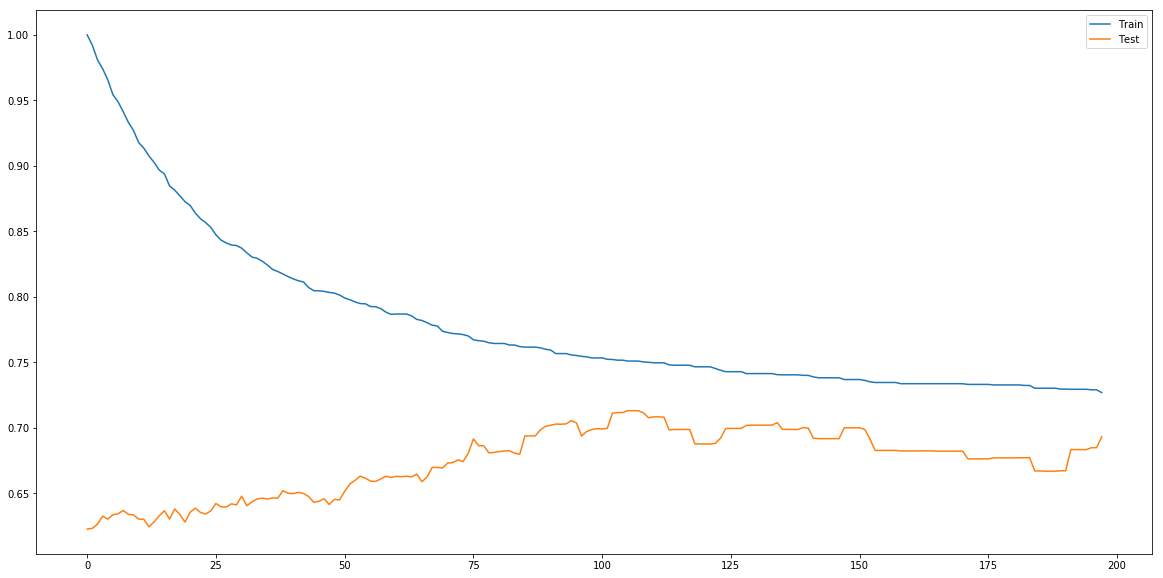

In [38]:
### One tuning on one paramete
'''
The parameter choose is the max_depth
'''

model_accuracies = defaultdict(list)




test_range = list(range(2, 200))
for min_samp in test_range:
    model = DecisionTreeClassifier(random_state=rs, min_samples_split = min_samp)
    model.fit(X_train, y_train)
    model_accuracies['Train'].append(model.score(X_train, y_train))
    model_accuracies['Test'].append(model.score(X_test, y_test))

plt.figure(figsize=(20,10))
for key in model_accuracies.keys():
    plt.plot(model_accuracies[key], label=key)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('min_sample_split',fontsize=15)
plt.legend(loc='upper right')

## 2. Python: Build another decision tree tuned with GridSearchCV

In [39]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(1, 500, 50)),
          'splitter': ['best', 'random'],
          'min_samples_leaf': range(1,  4),
          'min_samples_split': [2, 50, 100, 150],
          'max_features':['auto','sqrt','log2', None],
          'class_weight':['balanced', None]
         }

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 51, 101, 151, 201, 251, 301, 351, 401, 451], 'splitter': ['best', 'random'], 'min_samples_leaf': range(1, 4), 'min_samples_split': [2, 50, 100, 150], 'max_features': ['auto', 'sqrt', 'log2', None], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the classification accuracy on training and test datasets?

In [40]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))


# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
# print the confusion matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred)) ## Confusion Matrix on the TestSet

dt_model = cv.best_estimator_

Train accuracy: 0.7071808510638298
Test accuracy: 0.7238608052720406
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     10832
           1       0.25      0.59      0.36      1611

   micro avg       0.72      0.72      0.72     12443
   macro avg       0.59      0.67      0.59     12443
weighted avg       0.84      0.72      0.76     12443

Confusion Matrix: 
 [[8060 2772]
 [ 664  947]]


### b. What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?

In [41]:
print("Number of nodes: ", cv.best_estimator_.tree_.node_count)

Number of nodes:  335


### c. How many leaves are in the tree that is selected based on the validation dataset?

In [ ]:
print("The number of leaves is ",calculate_num_leaves(dt_model));

### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [48]:
analyse_feature_importance(cv.best_estimator_, feature_names, 1)
print("The competing splits for the first split is: ", model.tree_.threshold[0])

WheelType_? : 0.5211129846724725
The competing splits for the first split is:  0.5


In [22]:
visualize_decision_tree(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct_CV.png")

### e. What are the 5 important variables in building the tree? 

In [47]:
analyse_feature_importance(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, 5)

WheelType_? : 0.5211129846724725
MMRCurrentAuctionCleanPrice : 0.07277142785733536
VehYear_2008.0 : 0.04202254443575213
Auction_manheim : 0.023447446861988228
VehYear_2001.0 : 0.01924086900242204


### f. Report if you see any evidence of model overfitting. 

In [49]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

Train accuracy: 0.7071808510638298
Test accuracy: 0.7238608052720406


Since the accuracy on the training set is much larger than the test set, it may has the overfitting problem. # Ly pls modify this

### g. What are the parameters used? Explain your choices.

In [50]:
print("The best params of DT: ", cv.best_params_)

The best params of DT:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 51, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 150, 'splitter': 'random'}


## 3. What is the significant difference do you see between these two decision tree models (steps 2.1 & 2.2)? How do they compare performance-wise? Explain why those changes may have happened. 

In [52]:
print("Defualt Model: \n")
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print("Classification report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred)) ## Confusion Matrix on the TestSet

print("\n\n")

print("GridSearch Model: \n")
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
y_pred = cv.predict(X_test)
print("Classification report: \n",classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred)) ## Confusion Matrix on the TestSet

'''

From the classification report and the confusion matrix

'''


### And anaylse the different from the classification report and the best params

Defualt Model: 

Train accuracy: 0.7268617021276595
Test accuracy: 0.6930804468375794
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.71      0.80     10832
           1       0.23      0.60      0.34      1611

   micro avg       0.69      0.69      0.69     12443
   macro avg       0.58      0.65      0.57     12443
weighted avg       0.83      0.69      0.74     12443

Confusion Matrix: 
 [[7654 3178]
 [ 641  970]]



GridSearch Model: 

Train accuracy: 0.7071808510638298
Test accuracy: 0.7238608052720406
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.74      0.82     10832
           1       0.25      0.59      0.36      1611

   micro avg       0.72      0.72      0.72     12443
   macro avg       0.59      0.67      0.59     12443
weighted avg       0.84      0.72      0.76     12443

Confusion Matrix: 
 [[8060 2772]
 [ 664  947]]


'\n\nFrom the classification report and the confusion matrix\n\n'

## 4. From the better model, can you identify which cars could potential be “kicks”? Can you provide some descriptive summary of those cars?

In [ ]:
'''
print out all the classified kicks, from y_test to take the x_test out 
-> check the length and add the name of features to the value(feature_names).
'''

# Task 3. Predictive Modeling Using Regression

## 1. In preparation for regression, is any imputation of missing values needed for this data set? List the variables that needed this.

In [69]:
'''
We apply imputation on all of the columns except the dropped columns
'''

print("The Columns apply Imputation: \n", list(feature_names_beforDummy))

The Columns apply Imputation: 
 ['Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale']


## 2. Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

In [70]:
## Doing the log transformation


### Q: It's enoguh?
columns_to_transform = interval_cols

def logTransformation(df):
    
    df_log = df.copy()

    
    for col in columns_to_transform:
        df_log[col] = df_log[col].apply(lambda x: x+1)
        df_log[col] = df_log[col].apply(np.log)
        
        
    return df_log

df_log = logTransformation(df)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df_log.drop(['IsBadBuy'], axis=1), df_log['IsBadBuy'], test_size=0.3, stratify=df_log['IsBadBuy']
,random_state=rs)


if ResamplingMethod == 'ros':
    print("Using ROS Resmapling")
    ros = RandomOverSampler(random_state=rs)
    X_train_log, y_train_log = ros.fit_resample(X_train_log, y_train_log)
elif  ResamplingMethod == 'rus':
    print("Using RUS Resmapling")
    rus = RandomUnderSampler(random_state=rs)
    X_train_log, y_train_log = rus.fit_resample(X_train_log, y_train_log)
else:
    print("No Resampling Method Used")



# Standardise
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)


Using RUS Resmapling


## 3. Build a regression model using the default regression method with all inputs. Once you done it, build another one and tune it using GridSearchCV. Answer the followings:

In [71]:
### Traing Logistic Regression
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
## GridSearch for Logistic Regression
params = {
    'C': [pow(10, x) for x in range(-4, 1)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50, 100],
    'warm_start': [True, False],
    'class_weight':['balanced', None]
}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=3, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50, 100], 'warm_start': [True, False], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### h. Name the regression function used.

In [ ]:
'''
The regression function use the sigmoid function as the activation function at output layer.
'''

### i. How much was the difference in performance of two models build, default and optimal?

In [73]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))

Train accuracy: 0.7015957446808511
Test accuracy: 0.7577754560797235
GridSearch Train accuracy: 0.7007978723404256
GridSearch Test accuracy: 0.7580165554930482


### j. Show the set parameters for the best model. What are the parameters used? Explain your decision. What are the optimal parameters?

In [74]:
print("The best model parameters: ", cv.best_params_)

The best model parameters:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'saga', 'warm_start': True}


### k. Report which variables are included in the regression model.

In [78]:
# Print all features
print("Features used: \n")

for name in feature_names:
    print( name +", ")

Features used: 

VehOdo, 
MMRAcquisitionAuctionAveragePrice, 
MMRAcquisitionAuctionCleanPrice, 
MMRAcquisitionRetailAveragePrice, 
MMRAcquisitonRetailCleanPrice, 
MMRCurrentAuctionAveragePrice, 
MMRCurrentAuctionCleanPrice, 
MMRCurrentRetailAveragePrice, 
MMRCurrentRetailCleanPrice, 
MMRCurrentRetailRatio, 
VehBCost, 
WarrantyCost, 
Auction_adesa, 
Auction_manheim, 
Auction_other, 
VehYear_2001.0, 
VehYear_2002.0, 
VehYear_2003.0, 
VehYear_2004.0, 
VehYear_2005.0, 
VehYear_2006.0, 
VehYear_2007.0, 
VehYear_2008.0, 
VehYear_2009.0, 
VehYear_2010.0, 
VehYear_UNKNOWN_VALUE, 
Make_acura, 
Make_buick, 
Make_cadillac, 
Make_chevrolet, 
Make_chrysler, 
Make_dodge, 
Make_ford, 
Make_gmc, 
Make_honda, 
Make_hyundai, 
Make_infiniti, 
Make_isuzu, 
Make_jeep, 
Make_kia, 
Make_lexus, 
Make_lincoln, 
Make_mazda, 
Make_mercury, 
Make_mini, 
Make_mitsubishi, 
Make_nissan, 
Make_oldsmobile, 
Make_pontiac, 
Make_saturn, 
Make_scion, 
Make_subaru, 
Make_suzuki, 
Make_toyota, 
Make_volkswagen, 
Make_volvo

### l. Report the top-5 important variables (in the order) in the model.

In [79]:
def printLRTopImportant(model, top = 5):
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

In [80]:
printLRTopImportant(model, 5)

MMRAcquisitionRetailAveragePrice : 1.2399367200741878
MMRAcquisitionAuctionAveragePrice : -1.0333109477194544
MMRCurrentRetailCleanPrice : -0.6957406495028085
WheelTypeID_? : 0.5797343310892066
MMRCurrentAuctionCleanPrice : 0.5653353087715113


### m. What is classification accuracy on training and test datasets?

In [82]:
y_pred = model.predict(X_test_log)
print("Classification Report: \n\n",classification_report(y_test_log, y_pred))
print("Default Model Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

y_pred = cv.predict(X_test_log)
print("GridSearch Classification Report: \n\n",classification_report(y_test_log, y_pred))
print("GridSearch Confusion Matrix:\n ", confusion_matrix(y_test, y_pred))
log_reg_model = cv.best_estimator_

Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.60      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443

Default Model Confusion Matrix: 
 [[8458 2374]
 [ 640  971]]
GridSearch Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.59      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.84      0.76      0.79     12443

GridSearch Confusion Matrix:
  [[8484 2348]
 [ 663  948]]


### n. Report any sign of overfitting.

In [83]:
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))

GridSearch Train accuracy: 0.7007978723404256
GridSearch Test accuracy: 0.7580165554930482


In [84]:
'''
According to the training and test accuracy, the overfitting doesn't occur.
'''

"\nAccording to the training and test accuracy, the overfitting doesn't occur.\n"

## 4. Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [85]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=3)
rfe.fit(X_train_log, y_train_log)
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

selectmodel = SelectFromModel(dt_model, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

### a. Report which variables are included in the regression model.

In [86]:
print("Original feature set", X_train.shape[1])
print("Number of RFE-selected features: ", rfe.n_features_)
print("Number of selectFromModel features: ",  X_train_sel_model.shape[1])

Original feature set 149
Number of RFE-selected features:  39
Number of selectFromModel features:  19


In [87]:
print("The RFE-selected features: \n\n", list(compress(feature_names, rfe.support_)))
print("\n\n")
print("The SelectFromModel features: \n\n",list(compress(feature_names, selectmodel.get_support())))

The RFE-selected features: 

 ['VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'VehYear_2001.0', 'VehYear_2002.0', 'VehYear_2006.0', 'VehYear_2007.0', 'VehYear_2008.0', 'Make_chevrolet', 'Make_honda', 'Make_infiniti', 'Make_lexus', 'Make_lincoln', 'Make_mini', 'Make_nissan', 'Make_subaru', 'Make_toyota', 'WheelTypeID_1', 'WheelTypeID_?', 'WheelType_?', 'WheelType_alloy', 'WheelType_covers', 'Nationality_top line asian', 'Size_large', 'Size_large suv', 'Size_medium', 'Size_medium suv', 'PRIMEUNIT_no', 'PRIMEUNIT_NULL', 'VNST_nc', 'VNST_ne', 'VNST_pa']



The SelectFromModel features: 

 ['VehOdo', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'WarrantyCost', 'Auction_manheim', 'VehYear_2001.0', 'VehYear_2002.0', 'VehYear_2003.0', 'VehYear_

### b. Report the top-5 important variables (in the order) in the model.

In [88]:
params = {
    'C': [pow(10, x) for x in range(-4, 1)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50, 100],
    'warm_start': [True, False],
    'class_weight':['balanced', None]

}
rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs, verbose=True), cv=3, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)

selectModel_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs, verbose=True), cv=3, n_jobs=-1)
selectModel_cv.fit(X_train_sel_model, y_train_log)


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50, 100], 'warm_start': [True, False], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
print("Top-5 important variables for RFE: \n")
printLRTopImportant(rfe_cv.best_estimator_, 5)
print("\n\n")
print("Top-5 important variables for selectModel \n")
printLRTopImportant(selectModel_cv.best_estimator_, 5)

Top-5 important variables for RFE: 

VehYear_UNKNOWN_VALUE : 0.4727162468237619
Make_acura : 0.4700722937857108
MMRCurrentRetailRatio : -0.3254220626068507
Make_cadillac : -0.25038790228715707
Make_honda : -0.2436901274198032



Top-5 important variables for selectModel 

Auction_adesa : 1.0069671590927152
MMRCurrentAuctionAveragePrice : 0.21930939185872309
MMRCurrentAuctionCleanPrice : 0.20806570908782507
VehBCost : -0.19390947086708113
WarrantyCost : -0.15780280831420512


### c. What are the parameters used? Explain your choices. What are the optimal parameters? Which regression function is being used?

In [90]:
print("Optimal Parameters for RFE", rfe_cv.best_params_)
print("Optimal Parameters for selectModel", selectModel_cv.best_params_)

Optimal Parameters for RFE {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'liblinear', 'warm_start': True}
Optimal Parameters for selectModel {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'newton-cg', 'warm_start': True}


### d. Report any sign of overfitting

In [91]:
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))

GridSearch Train accuracy: 0.7007978723404256
GridSearch Test accuracy: 0.7580165554930482


In [92]:
'''
No Overfitting occurs in this model ## Ly modify this
'''

'\nNo Overfitting occurs in this model ## Ly modify this\n'

### e. What is classification accuracy on training and test datasets?

In [93]:
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))
print("\n\nRFE:\n")
print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("\n\nselectModel:\n")
print("Train accuracy:", selectModel_cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", selectModel_cv.score(X_test_sel_model, y_test_log))

GridSearch Train accuracy: 0.7007978723404256
GridSearch Test accuracy: 0.7580165554930482


RFE:

Train accuracy: 0.6922872340425532
Test accuracy: 0.7647673390661416


selectModel:

Train accuracy: 0.6873670212765958
Test accuracy: 0.762356344932894


### f. Did it improve/worsen the performance? Explain why those changes may have happened

In [94]:
y_pred = rfe_cv.predict(X_test_rfe)
print("REF classification report: \n",classification_report(y_test, y_pred))
print("REF Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n\n")
y_pred = selectModel_cv.predict(X_test_sel_model)
print("selectModel classification report: \n",classification_report(y_test, y_pred))
print("selectModel Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


REF classification report: 
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     10832
           1       0.29      0.57      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.68      0.62     12443
weighted avg       0.84      0.76      0.79     12443

REF Confusion Matrix: 
 [[8597 2235]
 [ 692  919]]



selectModel classification report: 
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     10832
           1       0.29      0.56      0.38      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.60      0.67      0.62     12443
weighted avg       0.84      0.76      0.79     12443

selectModel Confusion Matrix: 
 [[8589 2243]
 [ 714  897]]


In [ ]:
'''
The performance...

'''

 # Task4 - Predicting using neural network

## 1. Build a Neural Network model using the default setting. Answer the following:

In [95]:
model = MLPClassifier(random_state=rs)
model.fit(X_train_log, y_train_log)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### a. What is the network architecture?

In [96]:
def printMLPArchitecture(model):

    print("Number of Layers: ",model.n_layers_ )
    print("The First layer is Input Layer, and the last layer is the output layer")
    for i, w in enumerate(model.coefs_):
        print("{} Layer with hidden size {}".format(i+1, w.shape[0]))
        if (i+1) == len(model.coefs_):
            print("{} Layer with hidden size {}".format(i+2, w.shape[1]))
    
    print("The activation function: ", model.activation)
            
printMLPArchitecture(model)

Number of Layers:  3
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 100
3 Layer with hidden size 1
The activation function:  relu


### b. How many iterations are needed to train this network?

In [97]:
print("Number of iterations it ran: ", model.n_iter_)

Number of iterations it ran:  200


### c. Do you see any sign of over-fitting?

In [ ]:
print("MLP Train accuracy:", model.score(X_train, y_train))
print("MLP Test accuracy:", model.score(X_test, y_test))
# No overfitting sign in this model ## Ly modify this

In [ ]:
'''
The training accuracy and the test accuracy ...
'''

### d. Did the training process converge and resulted in the best model? 

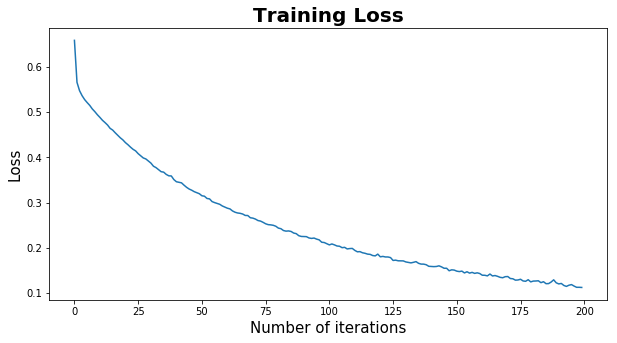

In [98]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(model.loss_curve_, label="Training Loss")

### The Loss curve is still decreasing

In [ ]:
'''
The loss curve is still decreasing. Therefore, it may not converge to the local minima yet.
'''

### e. What is classification accuracy on training and test datasets?

In [99]:
print("MLP Train accuracy:", model.score(X_train, y_train))
print("MLP Test accuracy:", model.score(X_test, y_test))
print("\n\n")
y_pred = model.predict(X_test)
print("MLP classification report: \n",classification_report(y_test, y_pred))
print("MLP Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


MLP Train accuracy: 0.5
MLP Test accuracy: 0.12955075142650485



MLP classification report: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     10832
           1       0.13      1.00      0.23      1611

   micro avg       0.13      0.13      0.13     12443
   macro avg       0.56      0.50      0.11     12443
weighted avg       0.89      0.13      0.03     12443

MLP Confusion Matrix: 
 [[    1 10831]
 [    0  1611]]


## 2. Refine this network by tuning it with GridSearchCV. 

In [108]:
# Default
# params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

params = [
    {
        'hidden_layer_sizes': [(128, 64, 32, 16), (128, 64,)],
        'activation': ['relu'],
        'solver' : ['adam',],
        'batch_size': [64],
        'shuffle': [True],
        'learning_rate_init': [0.001],
        'n_iter_no_change': [10, 20, 50],
        'max_iter':[200],
        'warm_start': [True],
        'early_stopping': [True],
        'alpha': [0.01, 0.001],
    },      
]


cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, verbose=True), cv=3, n_jobs=-1)
# cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, max_iter = max_iter, n_iter_no_change = max_iter ), cv=3, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

Iteration 1, loss = 0.61337294
Validation score: 0.664894
Iteration 2, loss = 0.54645272
Validation score: 0.670213
Iteration 3, loss = 0.52376250
Validation score: 0.664894
Iteration 4, loss = 0.50531999
Validation score: 0.679521
Iteration 5, loss = 0.48893488
Validation score: 0.668883
Iteration 6, loss = 0.47040820
Validation score: 0.658245
Iteration 7, loss = 0.45078621
Validation score: 0.655585
Iteration 8, loss = 0.43265201
Validation score: 0.660904
Iteration 9, loss = 0.41340565
Validation score: 0.638298
Iteration 10, loss = 0.39671538
Validation score: 0.636968
Iteration 11, loss = 0.38023418
Validation score: 0.652926
Iteration 12, loss = 0.36333683
Validation score: 0.630319
Iteration 13, loss = 0.34482327
Validation score: 0.664894
Iteration 14, loss = 0.32433501
Validation score: 0.662234
Iteration 15, loss = 0.30971697
Validation score: 0.663564
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(128, 64, 32, 16), (128, 64)], 'activation': ['relu'], 'solver': ['adam'], 'batch_size': [64], 'shuffle': [True], 'learning_rate_init': [0.001], 'n_iter_no_change': [10, 20, 50], 'max_iter': [200], 'warm_start': [True], 'early_stopping': [True], 'alpha': [0.01, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the network architecture?

In [109]:
print("Best Parameters of NN: ", cv.best_params_)

Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}


In [110]:
printMLPArchitecture(cv.best_estimator_)

Number of Layers:  4
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 128
3 Layer with hidden size 64
4 Layer with hidden size 1
The activation function:  relu


# b. How many iterations are needed to train this network?

In [111]:
print("Number of iterations it ran: ",cv.best_estimator_.n_iter_)

Number of iterations it ran:  15


### c. Sign of overfitting?

In [112]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))

# Since training accuracy is much larger than the test accuracy, it has the sign of overfitting.

GridSearch NN Train accuracy: 0.7601063829787233
GridSearch NN Test accuracy: 0.7480511130756249


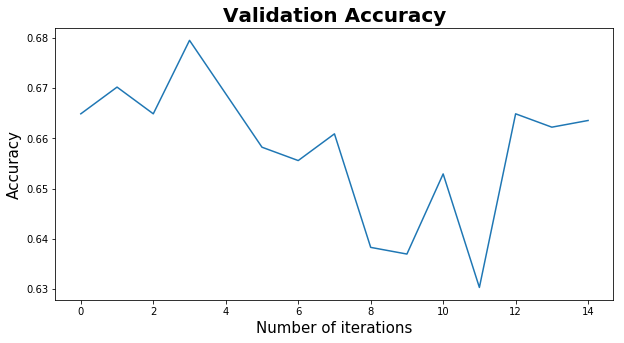

In [113]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Validation Accuracy',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.validation_scores_, label="Validation Accuracy")

In [114]:
'''
The training accuracy and the test accuracy...

Also, according to the validation accuracy curve

'''

'\nThe training accuracy and the test accuracy...\n\nAlso, according to the validation accuracy curve\n\n'

### d. Did the training process converge and resulted in the best model? 

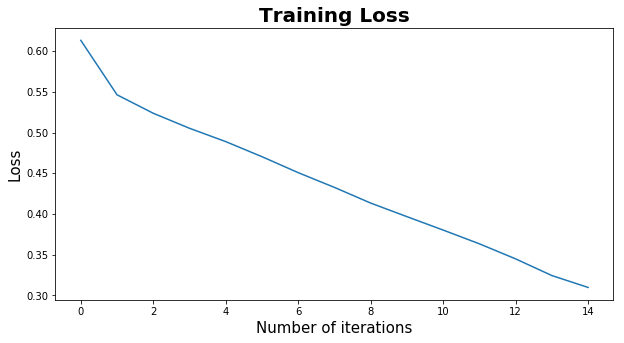

In [115]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="Training Loss")


### e. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [116]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))

print("\n\n")
y_pred = cv.predict(X_test_log)
print("GridSearch NN Classification Report: \n",classification_report(y_test_log, y_pred))
print("GridSearch NN Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


print("Best Parameters of NN: ", cv.best_params_)
nn_model = cv.best_estimator_

GridSearch NN Train accuracy: 0.7601063829787233
GridSearch NN Test accuracy: 0.7480511130756249



GridSearch NN Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.77      0.84     10832
           1       0.28      0.59      0.38      1611

   micro avg       0.75      0.75      0.75     12443
   macro avg       0.60      0.68      0.61     12443
weighted avg       0.84      0.75      0.78     12443

GridSearch NN Confusion Matrix: 
 [[8365 2467]
 [ 668  943]]
Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}


## 3. Would feature selection help here? Build another Neural Network model with inputs selected from RFE with regression (use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).

In [117]:
params = [
    {
        'hidden_layer_sizes': [(128, 64, 32, 16)],
        'activation': ['relu'],
        'solver' : ['adam',],
        'batch_size': [64],
        'shuffle': [True],
        'learning_rate_init': [0.001],
        'n_iter_no_change': [10],
        'max_iter':[200],
        'warm_start': [True],
        'early_stopping': [True],
        'alpha': [0.01, 0.001],
    },      
]



rfe_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, verbose=True), cv=3, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)
modelSelect_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, verbose=True), cv=3, n_jobs=-1)
modelSelect_cv.fit(X_train_sel_model, y_train_log)

Iteration 1, loss = 0.61470051
Validation score: 0.718085
Iteration 2, loss = 0.58055427
Validation score: 0.715426
Iteration 3, loss = 0.57342714
Validation score: 0.716755
Iteration 4, loss = 0.56871764
Validation score: 0.712766
Iteration 5, loss = 0.56372533
Validation score: 0.730053
Iteration 6, loss = 0.56260678
Validation score: 0.711436
Iteration 7, loss = 0.55895459
Validation score: 0.720745
Iteration 8, loss = 0.55625333
Validation score: 0.719415
Iteration 9, loss = 0.55558290
Validation score: 0.711436
Iteration 10, loss = 0.55411488
Validation score: 0.703457
Iteration 11, loss = 0.54903426
Validation score: 0.696809
Iteration 12, loss = 0.54797587
Validation score: 0.718085
Iteration 13, loss = 0.54614761
Validation score: 0.702128
Iteration 14, loss = 0.54422227
Validation score: 0.711436
Iteration 15, loss = 0.54354940
Validation score: 0.710106
Iteration 16, loss = 0.54495181
Validation score: 0.708777
Validation score did not improve more than tol=0.000100 for 10 co

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(128, 64, 32, 16)], 'activation': ['relu'], 'solver': ['adam'], 'batch_size': [64], 'shuffle': [True], 'learning_rate_init': [0.001], 'n_iter_no_change': [10], 'max_iter': [200], 'warm_start': [True], 'early_stopping': [True], 'alpha': [0.01, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. Did feature selection help here? Any change in the network architecture? What inputs are being used as the network input?

In [118]:
print("Best Parameters of NN: ", cv.best_params_)
print("Best Parameters of RFE NN: ", rfe_cv.best_params_)
print("Best Parameters of modelSelect NN: ", modelSelect_cv.best_params_)
print("\n\n")

print("GridSearch:")
printMLPArchitecture(cv.best_estimator_)
print("\n")
print("RFE:")
printMLPArchitecture(rfe_cv.best_estimator_)
print("\n")
print("modelSelect:")
printMLPArchitecture(modelSelect_cv.best_estimator_)
print("\n")


Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}
Best Parameters of RFE NN:  {'activation': 'relu', 'alpha': 0.01, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}
Best Parameters of modelSelect NN:  {'activation': 'relu', 'alpha': 0.01, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}



GridSearch:
Number of Layers:  4
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 128
3 Layer with hid

### b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [119]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))
print("RFE NN Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("RFE NNTest accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("modelSelect NN Train accuracy:", modelSelect_cv.score(X_train_sel_model, y_train_log))
print("modelSelect NN Test accuracmodelSelect_cvy:", modelSelect_cv.score(X_test_sel_model, y_test_log))

GridSearch NN Train accuracy: 0.7601063829787233
GridSearch NN Test accuracy: 0.7480511130756249
RFE NN Train accuracy: 0.7069148936170213
RFE NNTest accuracy: 0.772803986176967
modelSelect NN Train accuracy: 0.6900265957446808
modelSelect NN Test accuracmodelSelect_cvy: 0.7657317367194406


### c. How many iterations are now needed to train this network?

In [120]:
print("Number of iterations GS ran: ",cv.best_estimator_.n_iter_)
print("Number of iterations rfe ran: ",rfe_cv.best_estimator_.n_iter_)
print("Number of iterations modelSelect ran: ",modelSelect_cv.best_estimator_.n_iter_)

Number of iterations GS ran:  15
Number of iterations rfe ran:  16
Number of iterations modelSelect ran:  12


### d. Do you see any sign of over-fitting?

In [121]:
## From the training and test accuracy, we can see that both RFE NN and model_selected NN has the sign of overfitting

## Ly pls modify this.

### e. Did the training process converge and resulted in the best model? 

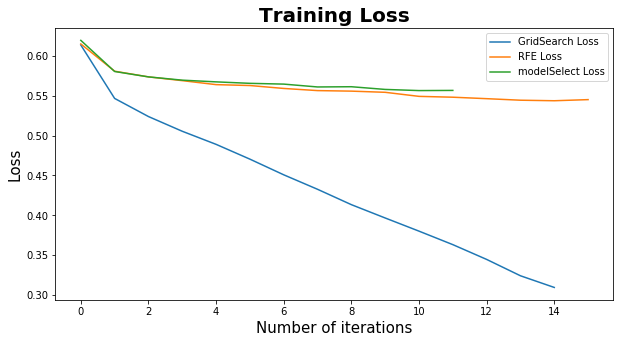

In [122]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="GridSearch Loss")
plt.plot(rfe_cv.best_estimator_.loss_curve_, label="RFE Loss")
plt.plot(modelSelect_cv.best_estimator_.loss_curve_, label="modelSelect Loss")
plt.legend(loc='upper right')

# 4. Using the comparison methods, which of the models (i.e one with selected variables and another with all variables) appears to be better? From the better model, can you identify cars those could potential be “kicks”? Can you provide some descriptive summary of those cars? Is it easy to comprehend the performance of the best neural network model for decision making?

In [123]:
print("GridSearch Classification Report: ")
y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n\nRFE Classification Report: ")
y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n\nmodelSelect Classification Report: ")
y_pred = modelSelect_cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

GridSearch Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     10832
           1       0.28      0.59      0.38      1611

   micro avg       0.75      0.75      0.75     12443
   macro avg       0.60      0.68      0.61     12443
weighted avg       0.84      0.75      0.78     12443

Confusion Matrix: 
 [[8365 2467]
 [ 668  943]]


RFE Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     10832
           1       0.30      0.55      0.39      1611

   micro avg       0.77      0.77      0.77     12443
   macro avg       0.61      0.68      0.62     12443
weighted avg       0.84      0.77      0.80     12443

Confusion Matrix: 
 [[8729 2103]
 [ 724  887]]


modelSelect Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     10832
           1       0.29      0.55      0

# Task 5. Generating an Ensemble Model and Comparing Models

## 1. Generate an ensemble model to include the best regression model, best decision tree model, and best neural network model.

In [124]:
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')
voting.fit(X_train_log, y_train_log)

y_pred_dt = dt_model.predict(X_test_log)
y_pred_log_reg = log_reg_model.predict(X_test_log)
y_pred_nn = nn_model.predict(X_test_log)
y_pred_ensemble = voting.predict(X_test_log)


Iteration 1, loss = 0.61337294
Validation score: 0.664894
Iteration 2, loss = 0.54645272
Validation score: 0.670213
Iteration 3, loss = 0.52376250
Validation score: 0.664894
Iteration 4, loss = 0.50531999
Validation score: 0.679521
Iteration 5, loss = 0.48893488
Validation score: 0.668883
Iteration 6, loss = 0.47040820
Validation score: 0.658245
Iteration 7, loss = 0.45078621
Validation score: 0.655585
Iteration 8, loss = 0.43265201
Validation score: 0.660904
Iteration 9, loss = 0.41340565
Validation score: 0.638298
Iteration 10, loss = 0.39671538
Validation score: 0.636968
Iteration 11, loss = 0.38023418
Validation score: 0.652926
Iteration 12, loss = 0.36333683
Validation score: 0.630319
Iteration 13, loss = 0.34482327
Validation score: 0.664894
Iteration 14, loss = 0.32433501
Validation score: 0.662234
Iteration 15, loss = 0.30971697
Validation score: 0.663564
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


### a. Does the Ensemble model outperform the underlying models? Resonate your answer.

In [125]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("DT Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))

print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test, y_pred_log_reg))

print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("NN Confusion Matrix: \n", confusion_matrix(y_test, y_pred_nn))

print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))
print("Ensemble Confusion Matrix: \n", confusion_matrix(y_test, y_pred_ensemble))


Report for DT: 
               precision    recall  f1-score   support

           0       0.90      0.70      0.79     10832
           1       0.18      0.45      0.26      1611

   micro avg       0.67      0.67      0.67     12443
   macro avg       0.54      0.58      0.52     12443
weighted avg       0.80      0.67      0.72     12443

DT Confusion Matrix: 
 [[7607 3225]
 [ 888  723]]

Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.59      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.84      0.76      0.79     12443

Logistic Regression Confusion Matrix: 
 [[8484 2348]
 [ 663  948]]

Report for NN: 
               precision    recall  f1-score   support

           0       0.93      0.77      0.84     10832
           1       0.28      0.59      0.38      1

## 2. Use the comparison methods (or the comparison node) to compare the best decision tree model, the best regression model, the best neural network model and the ensemble model. 

### a. Discuss the findings led by (a) ROC Chart (and Index); (b) Score Ranking (or Accuracy Score); (c) Fit Statistics; (or Classification report) and (4) Output.

(a) ROC Chart (and Index)

ROC index on test for DT: 0.7234527131601701
ROC index on test for logistic regression: 0.4997357932951725
ROC index on test for NN: 0.4994254557157357
ROC index on voting classifier: 0.7543744103270811


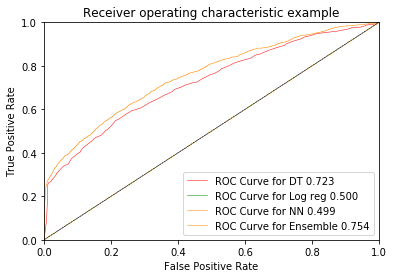

In [126]:
#### ROC

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)
y_pred_proba_ensemble = voting.predict_proba(X_test_log)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_ensemble = roc_auc_score(y_test_log, y_pred_proba_ensemble[:, 1])


print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on voting classifier:", roc_index_ensemble)


fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_pred_proba_ensemble[:,1])


plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_ensemble, tpr_ensemble, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_ensemble), color='darkorange', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

(b) Score Ranking (or Accuracy Score)

In [127]:
print("Accuracy score on test for DT:", accuracy_score(y_test_log, y_pred_dt))
print("Accuracy score on test for Logistic Regression:", accuracy_score(y_test_log, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test_log, y_pred_nn))
print("Accuracy score on test for Ensemble:", accuracy_score(y_test_log, y_pred_ensemble))

Accuracy score on test for DT: 0.6694527043317527
Accuracy score on test for Logistic Regression: 0.7580165554930482
Accuracy score on test for NN: 0.7480511130756249
Accuracy score on test for Ensemble: 0.7612312143373784


(c) Classification report

In [128]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))

Report for DT: 
               precision    recall  f1-score   support

           0       0.90      0.70      0.79     10832
           1       0.18      0.45      0.26      1611

   micro avg       0.67      0.67      0.67     12443
   macro avg       0.54      0.58      0.52     12443
weighted avg       0.80      0.67      0.72     12443


Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.59      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.84      0.76      0.79     12443


Report for NN: 
               precision    recall  f1-score   support

           0       0.93      0.77      0.84     10832
           1       0.28      0.59      0.38      1611

   micro avg       0.75      0.75      0.75     12443
   macro avg       0.60      0.68      0.61     12443
weig

(d) Output

In [129]:
### what's the the output? the confusion matrix or just the y_pred? ## Ly pls help me to answer this.

### b. Do all the models agree on the cars characteristics? How do they vary?

In [130]:
# what's this? ## Ly pls help me to answer this.

# Task 6. Final Remarks: Decision Making

## 1. Finally, based on all models and analysis,  is there a particular model you will use in decision making? Justify your choice. 

We will choose the ensemble model for making decision since it has the highest accuracy. Moreover, the ensemble model has 0.44 precission on the kicks, which means 0.44 it has 44% accuracy when it classify an observation as a kicks. Other model has a lower precision and recall, which means those models can't efficiently detect the "Kicks". If we want to apply this model in the real world, we would expect this model to detect suspecious cases, then apply further investigation on those cases.

## 2. Can you summarise positives and negatives of each predictive modelling method based on this analysis? 

The NN need more training time and the logistic model need more training time, the decision model and NN model has more serious overfitting problem. However, these two overfitting model have a higher accuracy on the test set. The logisit regression model and th

In [ ]:
# Add the measurement time to the basic model, 

# Also talk about that NN has lots of hyper-params, so need more time for searching params

## 3. How the outcome of this study can be used by decision makers? 

The decision maker can use the ensemble model for detecting the suspecious deals.